# TravelTide Customer Segmentation Using Fuzzy Segmentation:

**Introduction:**
Welcome to our Exploratory Data Analysis for TravelTide, a fictional e-booking startup. Our primary objective is to **segment customers**, with the ultimate aim of **identifying suitable incentives to improve customer retention**. In this notebook, we embark on the initial phase of our analysis **using Python, which involves comprehending the data, cleaning it, and preparing it for subsequent analytical processes**. The dataset we are working with results from a **SQL query** that combines information from four key tables:

**Table 1: Users - containing user demographic details.**

**Table 2: Sessions - providing insights into individual browsing sessions.**

**Table 3: Flights - furnishing information on purchased flights.**

**Table 4: Hotels - offering details on booked hotel stays.**

**Cohort Selection:**
In response to the **Marketing Manager's request**, we have selected a specific cohort. This **cohort** consists of sessions that commenced after the New Year's holiday **(starting from 2023-01-04)** and extends up to the last available date in our database **(2023-07-23)**. Furthermore, we have exclusively considered users who have engaged in **more than 7 sessions during this time frame**. This approach allows us to analyze customer behavior within a fixed temporal window.

In alignment with our recent meeting with the Marketing Manager, here are the incentives most likely to attract our customers:

**1. Complimentary hotel meals.**

**2. Free checked baggage.**

**3. Waived cancellation fees.**

**4. Exclusive discounts.**

**5. A one-night free hotel stay when booking a flight.**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For scaling the data
from sklearn.preprocessing import StandardScaler 

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set the ggplot style 
plt.style.use('ggplot')

# Load the dataset
# Make sure to replace the file path with the correct one on your system
file_path = 'Travel Tide Cohort Extract.csv'
cohort_users = pd.read_csv(file_path)

# Understanding Data and Managing Null Values:

Let's delve into an overview of our data to gain insights into the presence of null values.

In [6]:
# Check for null values in the dataset
null_counts = cohort_users.isnull().sum()

# Get the shape of the dataset (number of rows and columns)
data_shape = cohort_users.shape

# Check for duplicate rows
duplicate_rows = cohort_users[cohort_users.duplicated()]

# Check for duplicate columns
duplicate_columns = cohort_users.columns[cohort_users.columns.duplicated()]

# Display the results
print("Null Value Counts:")
print(null_counts)

print("\nData Shape (Rows, Columns):")
print(data_shape)

if not duplicate_rows.empty:
    print("\nDuplicate Rows:")
    print(duplicate_rows)

if not duplicate_columns.empty:
    print("\nDuplicate Columns:")
    print(duplicate_columns)

Null Value Counts:
user_id                                      0
sign_up_date                                 0
age                                          0
gender                                       0
married                                      0
has_children                                 0
home_country                                 0
home_city                                    0
age_group                                    0
session_count                                0
avg_session_duration_minute                  0
avg_page_clicks                              0
total_trips                                  0
conversion_rate                              0
weekend_trip_proportion                      0
cancellation_proportion                    432
avg_booking_departure_gap_days_flights     792
avg_booking_departure_gap_days_hotels      563
total_flights_booked                         0
round_trips_proportion                       0
avg_flight_price_usd                     

There appears to be an intriguing pattern in the distribution of null values:

we observe an equal count of null values in attributes associated with flights (booking_departure_gap_days_flights, avg_flight_price_usd, avg_flight_seats, avg_checked_bags, avg_distance_flown_km) and an identical count of null values in attributes tied to hotels (booking_departure_gap_days_hotels, avg_hotel_price_usd, avg_hotel_rooms, avg_stay_duration_day). 

This observation is promising, as it suggests that not all users have made bookings for both flights and hotels simultaneously.

Additionally, we've identified null values in cancellation_proportion, avg_flight_discount_amount, and avg_hotel_discount_amount. These null values are rational since not all users have been eligible for discounts on their bookings.

Considering our intention to implement **Fuzzy Segmentation and create new metrics using existing features**, the strategy for handling null values and data transformation takes on significant importance.

# Managing Null Values:

Let's systematically examine the significance of null values in each column and, based on their meaning, determine our strategy for handling them:

<u>**1. cancellation_proportion:**</u>
   - **Null Meaning:** Indicates that the user hasn't made any bookings.
   - **Zero Meaning:** Suggests that the user has booked at least one trip and has not canceled any.

   We plan to utilize this feature to calculate the last_min_booker_index in conjunction with avg_booking_departure_gap_days. This index will be used to offer the "No cancellation fee" perk. For our purposes, a higher cancellation_proportion and a lower avg_booking_departure_gap_days are favorable.

   Our approach for calculating the **last_min_booker_index will involve a weighted sum, and we want to ensure that null values in cancellation_proportion do not unduly skew or influence the index**.

   **Approach for Null Handling:**

   - **Fill with a Neutral Value:** Null values in cancellation_proportion signify that the user has not made any bookings. We can interpret this as a neutral stance regarding cancellation since these users have not engaged in the booking process at all. By filling nulls with the value of 0, we effectively assign a cancellation proportion of 0 to both users who haven't booked and those who booked but did not cancel. While the distinction is subtle, it aligns with the perspective of cancellation propensity.
   
   - **Flagging:** To further differentiate between users who have never booked and those who booked but did not cancel, even after null values are replaced with 0, we will introduce a binary column called "has_booked." This column will be set to True for users who have made bookings (regardless of whether they canceled) and False for users who have never made any bookings. This flag will prove useful if we need to analyze these user groups separately in the future.

<u>**2. Handling Null Values for avg_booking_departure_gap_days_flights and avg_booking_departure_gap_days_hotels:**</u>

The metrics for the time gap between booking and departure/check-in days are derived from the difference between the end of a user's browsing session and the departure time for flights or check-in time for hotels. I've included the hotel check-in time because not all users have booked both hotels and flights together. If you inspect the data, you'll notice that when both metrics are available, the flight gap tends to be larger than the hotel gap. Therefore, before determining how to handle null values, I'll merge these two columns by retaining the larger of the two values.

In [7]:
# Flagging users based on flight bookings: True if the user has booked a flight and False if they haven't.
cohort_users['has_booked'] = ~cohort_users['cancellation_proportion'].isna()

# Filling cancellation_proportion column null values with 0.
cohort_users['cancellation_proportion'].fillna(0, inplace=True)

In [8]:
# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_booking_departure_gap_days_hotels') + 1

# Calculate the maximum of the two columns and create a new column 'avg_booking_departure_gap_days'
cohort_users['avg_booking_departure_gap_days'] = cohort_users[['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels']].max(axis=1)

# Drop the original columns
cohort_users.drop(columns=['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels'], inplace=True)

# Check the number of null values in the new column 'avg_booking_departure_gap_days'
null_values = cohort_users['avg_booking_departure_gap_days'].isna().sum()
print(f'We have {null_values} null values in the avg_booking_departure_gap_days column.')

We have 432 null values in the avg_booking_departure_gap_days column.


**Considerations for Managing Null Values:**

**Null Meaning:** Indicates that the user has not booked either a flight or a hotel.

**Nature of Data:** This column represents the duration between the booking time and the departure time, signifying how early or last-minute a user books.

As previously mentioned, I will use this column in calculating the **last_min_booker_index, in conjunction with the cancellation_proportion.** In the formula, we subtract this value from the maximum gap in the dataset, meaning smaller values (indicative of last-minute bookings) will contribute more to the index.

For users who haven't made any bookings, their propensity to be last-minute bookers is essentially unknown. They neither booked early nor late. We require a strategy that neither disproportionately rewards nor penalizes these users in the final index.

**Approach for Null Handling:**

**Max Value Imputation:** To ensure that users who haven't booked are neither advantaged nor disadvantaged in the last_min_booker_index calculation, we can impute their gaps with the maximum gap value in the dataset. By using the maximum value, users who haven't booked effectively receive a neutral score in the last_min_booker_index calculation. This approach ensures they are neither classified as early bookers nor last-minute bookers.

**Flagging:** In addition to flagging users based on the cancellation_proportion column (using has_booked), which indirectly captures users who haven't booked a flight or hotel, this flag also serves to indicate their booking behavior.

In [9]:
max_gap = cohort_users['avg_booking_departure_gap_days'].max()
cohort_users['avg_booking_departure_gap_days'].fillna(max_gap, inplace=True)

# Check the number of null values in the new column 'avg_booking_departure_gap_days'
null_values = cohort_users['avg_booking_departure_gap_days'].isna().sum()
print(f'We have {null_values} null values in the avg_booking_departure_gap_days column.')

We have 0 null values in the avg_booking_departure_gap_days column.


<u>**3. Handling Null Values for Flight-related Columns:**</u>

Let's address the handling of null values in flight-related columns, specifically **avg_flight_price_usd**, **avg_flight_discount_amount**, **avg_flight_seats**, **avg_checked_bags**, and **avg_distance_flown_km**:

**Null Meaning**: Null values in these columns indicate that the user has not booked a flight, or in the case of **avg_flight_discount_amount**, the user has not received any discounts on flight bookings.

These columns play a crucial role in creating new metrics, starting with the calculation of the average dollar saved per kilometer using the formula:

**avg_usd_saved_per_km** = **avg_flight_discount_amount** * **avg_flight_price_usd** / **avg_distance_flown_km**

Subsequently, these metrics contribute to the calculation of another index, the **bargain_hunting_index**, using a weighted average method. This index is vital for categorizing our price-sensitive customers and offering them the "Exclusive Discounts" perk.

The **bargain_hunting_index** is calculated using the formula:

**bargain_hunting_index** = **w1** * conversion_rate + **w2** * scaled_avg_session_duration_minute + **w3** * scaled_avg_page_clicks + **w4** * avg_flight_discount_amount + **w5** * discounted_flight_proportion + **w6** * avg_hotel_discount_amount + **w7** * discounted_hotel_proportion + **w8** * scaled_avg_usd_saved_per_km

Where **w1-w8** represent the weights for each metric.

Approach for Null Handling:

Our approach should prioritize preserving the meaningfulness of the derived metrics and avoid introducing unnecessary bias in the final index. Here's how we will handle null values:

1. **Flagging**: We will flag users who haven't booked a flight. This provides us with the flexibility to treat them differently in future analyses if necessary.

2. **avg_flight_discount_amount**: Since null values here indicate that the user never booked a flight and, consequently, never received a discount, we will set these null values to zero. This accurately reflects that they saved nothing on their flights.

3. **avg_distance_flown_km**: This column is used to calculate **avg_usd_saved_per_km**, and a null or zero value would lead to an undefined metric. To address this, we will replace null values in this column with the median. This assigns users who haven't flown a value for **avg_usd_saved_per_km** that is representative of an average user. It assumes that if they were to book a flight, their behavior might align with the average.

4. **avg_flight_price_usd**: Instead of using zero, which might suggest that a user booked a free flight (potentially misleading), we will replace null values with the median. This implies that the user has a typical spending pattern for flights, even though they haven't booked one. This approach assumes that if they were to book, their booking price would align with the median.

5. **avg_flight_seats & avg_checked_bags**: These metrics represent the average number of seats booked and checked bags per flight, indicating group size. Null values in both columns will be filled with 0, signifying that these users haven't booked any seats or checked any bags. This approach is logical since higher values are more attractive for perks like Free hotel meals and Free checked bags, naturally ranking non-flyers lower.

In [10]:
# Flag users who haven't booked a flight
cohort_users['has_booked_flight'] = ~cohort_users['avg_flight_price_usd'].isna()

# Define columns to fill with 0
zero_fill_columns = ['avg_flight_discount_amount', 'avg_flight_seats', 'avg_checked_bags']

# Define columns to fill with their medians
median_fill_columns = ['avg_flight_price_usd', 'avg_distance_flown_km']

# Fill null values with zero for specified columns
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# Fill null values with median for specified columns
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

<u>**4. Handling Null Values for Hotel-related Columns:**</u>

Now, let's address the handling of null values in hotel-related columns, specifically **avg_hotel_price_usd**, **avg_hotel_discount_amount**, **avg_hotel_rooms**, and **avg_stay_duration_day**:

**Null Meaning**: Null values in these columns indicate that the user has not booked a hotel, or in the case of **avg_hotel_discount_amount**, the user has not received any discounts on hotel bookings.

These columns are pivotal for creating new metrics, including the previously mentioned **bargain_hunting_index**, where **avg_hotel_discount_amount** will be one of the contributing factors. Additionally, we plan to calculate an index to segment users for offering perks such as Free hotel meals and Free checked bags. In this context, **avg_hotel_rooms**, **avg_hotel_price_usd**, and **avg_stay_duration_day** play important roles. Higher values for **avg_hotel_rooms**, lower **avg_hotel_price_usd**, and higher **avg_stay_duration_day** are all favorable for this index.

**Approach for Null Handling:**

1. **Flagging**: As before, we will flag users who haven't booked a hotel. Given the context provided and the intended usage of these columns, here's how we will handle null values:

2. **avg_hotel_price_usd**: Using zero would imply that a user booked a hotel for free, potentially misleading the data analysis. Instead, we will replace null values with the median. This approach implies that the user has a typical spending pattern for hotels, even though they haven't booked one. This assumption is based on the idea that if they were to book, their booking price would be close to the median.

3. **avg_hotel_discount_amount**: Null values indicate that the user hasn't booked a hotel and therefore hasn't received any discounts. We can fill these null values with 0, signifying that the user didn't save anything on hotel bookings. This approach supports the "bargain_hunting_index" calculation, as users who haven't availed any discounts will be positioned at the lower end of the index.

4. **avg_hotel_rooms**: If a user hasn't booked a hotel, it means they've booked 0 rooms. Filling null values with 0 is logical for this column.

5. **avg_stay_duration_day**: A user who hasn't booked a hotel hasn't stayed for any number of days. Filling null values with 0 is reasonable in this context, especially because we associate longer stays with the Free checked bags perk.

In [11]:
# Flag users who haven't booked a hotel
cohort_users['has_booked_hotel'] = ~cohort_users['avg_hotel_price_usd'].isna()

# Define columns to fill with 0
zero_fill_columns = ['avg_hotel_discount_amount', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Define columns to fill with their medians
median_fill_columns = ['avg_hotel_price_usd']

# Fill null values with zero for specified columns
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# Fill null values with median for specified columns
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

# Check the number of null values
null_values = cohort_users.isna().sum().sum()
print(f'There are {null_values} Null values in the dataset.')

There are 0 Null values in the dataset.


<u>**Checking Statistical Summary:**</u>

Before we embark on creating new metrics, it's essential to scale the existing features, and prior to that, we must address any outliers in our data.

In [12]:
# Exclude the 'user_id' column as it doesn't make sense to include it in the statistical summary
selected_columns = cohort_users.columns.difference(['user_id'])

# Generate the statistical summary for selected columns and transpose for readability
statistical_summary = cohort_users[selected_columns].describe().T

# Display the statistical summary
print(statistical_summary)

                                 count         mean          std    min  \
age                             5998.0    40.357953    12.049011  15.00   
avg_booking_departure_gap_days  5998.0    46.304813    99.703231   1.50   
avg_checked_bags                5998.0     0.523671     0.519474   0.00   
avg_distance_flown_km           5998.0  2302.206816  1633.915771  27.52   
avg_flight_discount_amount      5998.0     0.110989     0.085397   0.00   
avg_flight_price_usd            5998.0   529.420250   691.082171   5.35   
avg_flight_seats                5998.0     1.061144     0.591982   0.00   
avg_hotel_discount_amount       5998.0     0.076164     0.068848   0.00   
avg_hotel_price_usd             5998.0   176.839388    80.723534  24.00   
avg_hotel_rooms                 5998.0     1.085792     0.484330   0.00   
avg_page_clicks                 5998.0    18.782508    11.969869   4.13   
avg_session_duration_minute     5998.0     1.780123     1.602640   0.00   
avg_stay_duration_day    

There is an unusual minimum value in the **avg_stay_duration_day column, which stands at -1.** To investigate further, I conducted a thorough examination of the hotel's table in the database using SQL queries. **It appears that these negative values are anomalies stemming from instances where the check-out time occurred before the check-in time.** Let's quantify the extent of this issue:

In [13]:
# Find records with negative values in 'avg_stay_duration_day' column
negative_records = cohort_users[cohort_users['avg_stay_duration_day'] < 0]

# Calculate the count and percentage of records with negative values
negative_count = negative_records.shape[0]
total_count = cohort_users['avg_stay_duration_day'].count()
percentage = round((negative_count / total_count) * 100, 2)

# Display the information about negative values
print(f'Only {negative_count} records ({percentage}%) of the "avg_stay_duration_day" column have negative values.')

Only 2 records (0.03%) of the "avg_stay_duration_day" column have negative values.


Fortunately, it appears to be relatively minor.

Given that **avg_stay_duration_day represents the average stay duration**, I dug deeper with SQL queries to identify how many individual records in the entire cohort exhibited negative stay durations. It turns out, **out of 5998 records, only 15 of them had this issue**. As such, it does not pose a significant concern.

**To resolve this matter, I'll replace these two records with a stay duration of 0.**

In [14]:
# Replace negative values in 'avg_stay_duration_day' column with 0
cohort_users['avg_stay_duration_day'] = cohort_users['avg_stay_duration_day'].clip(lower=0)

# Count the number of records with negative values
negative_count = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]

# Print the updated count of records with negative values
print(f'Now {negative_count} records in the "avg_stay_duration_day" column have been replaced with 0 or are non-negative.')

# Excluding user_id column as it doesn't make sense to get its statistical summary
selected_columns = cohort_users.columns.difference(['user_id'])

# Generate the statistical summary for selected columns
summary = cohort_users[selected_columns].describe().T
print("\nStatistical Summary of Selected Columns:")
print(summary)

Now 0 records in the "avg_stay_duration_day" column have been replaced with 0 or are non-negative.

Statistical Summary of Selected Columns:
                                 count         mean          std    min  \
age                             5998.0    40.357953    12.049011  15.00   
avg_booking_departure_gap_days  5998.0    46.304813    99.703231   1.50   
avg_checked_bags                5998.0     0.523671     0.519474   0.00   
avg_distance_flown_km           5998.0  2302.206816  1633.915771  27.52   
avg_flight_discount_amount      5998.0     0.110989     0.085397   0.00   
avg_flight_price_usd            5998.0   529.420250   691.082171   5.35   
avg_flight_seats                5998.0     1.061144     0.591982   0.00   
avg_hotel_discount_amount       5998.0     0.076164     0.068848   0.00   
avg_hotel_price_usd             5998.0   176.839388    80.723534  24.00   
avg_hotel_rooms                 5998.0     1.085792     0.484330   0.00   
avg_page_clicks                 59

# Treating Outliers:

Upon reviewing the statistical summary, we observe that most columns exhibit mean and median values that are closely aligned. To gain deeper insights into the distribution of our data and identify any potential outliers, we will visualize the distributions using histograms. Additionally, we will employ box plots to further assess the presence of outliers.

Important Note: **We have defined outliers as data points lying five standard deviations away from the sample mean.** It's worth noting that an event with data deviating by 5 standard deviations corresponds to a probability of approximately 1 in 500 million under the assumption of normality. Therefore, we can confidently conclude that these data points are rare.

To facilitate this analysis, I've developed a function that generates histograms for all numeric columns, excluding the user_id. I've also applied Sturges' formula to calculate the optimal number of bins for each histogram. This approach ensures that we avoid using a fixed number of bins for all columns, as different columns may have distinct data distribution patterns.

While considering alternative rules for bin calculation, such as the Square-root Rule, Rice Rule, and Freedman-Diaconis Rule, we determined that Sturges' formula yielded the most informative results. The other methods produced noisy outcomes with excessive bins. While manually specifying the number of bins for each column is an option, it may not be ideal due to the variability in data distribution across columns.

**Some Key Points to Consider:**

1. The visualizations we've conducted have yielded valuable insights into the data distribution, empowering us to make informed decisions for our analysis.

2. It's worth noting that our chosen threshold of 5 times the standard deviation (5*STD) is relatively permissive, and data points beyond this range are highly likely to be outliers.

3. Furthermore, it's evident that several columns contain data points that surpass the 5*STD threshold. Notably, certain columns, such as **avg_session_duration_minute**, exhibit a substantial proportion of data points extending beyond this threshold.

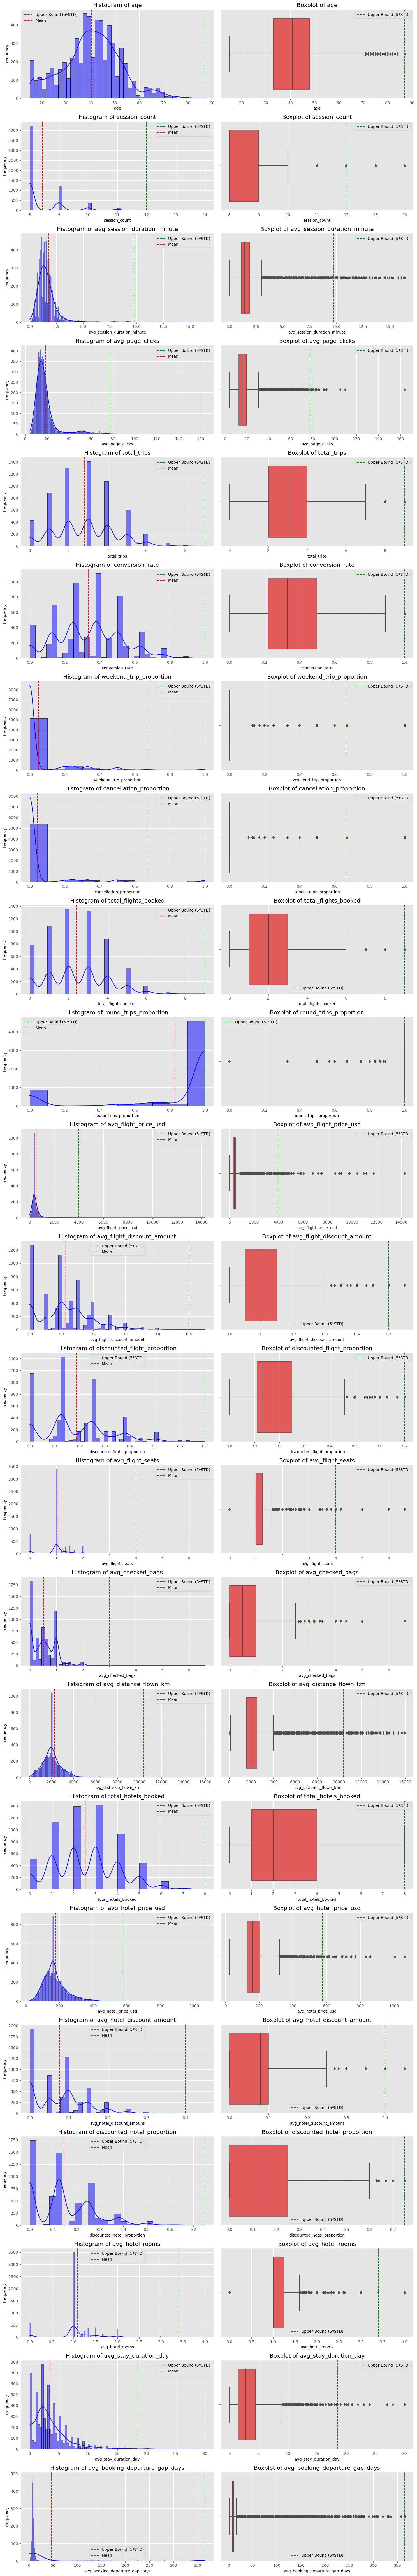

In [15]:
# Select only numerical columns and exclude the user_id column
numerical_columns = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

# Set up the figure and axes
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(15, 4 * len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    # Compute the upper bound for outliers using the Z-score method
    z_scores = (cohort_users[col] - cohort_users[col].mean()) / cohort_users[col].std()
    upper_bound = cohort_users[col][z_scores <= 5].max()
    mean = cohort_users[col].mean()
    
    # Calculate the number of bins using Freedman-Diaconis Rule with a minimum of 10 bins
    iqr = cohort_users[col].quantile(0.75) - cohort_users[col].quantile(0.25)
    bin_width = 2 * iqr / (len(cohort_users[col]) ** (1/3))
    
    # Set a minimum number of bins to prevent division by zero or infinite bin_width
    min_bins = 10
    max_value = cohort_users[col].max()
    min_value = cohort_users[col].min()
    if bin_width == 0:
        # If bin_width is zero, use a default value for bins
        bins = min_bins
    else:
        bins = max(min_bins, int((max_value - min_value) / bin_width))
    
    # Plot histogram with a green KDE line
    sns.histplot(cohort_users[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black', color='blue',
                 line_kws={'color': 'green'})  # Use line_kws to set the KDE line color
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].axvline(upper_bound, color='g', linestyle='--', label=f'Upper Bound (5*STD)')
    axes[i, 0].axvline(mean, color='r', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot with a different color (e.g., red)
    sns.boxplot(x=cohort_users[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7), color='red')
    axes[i, 1].axvline(upper_bound, color='g', linestyle='--', label=f'Upper Bound (5*STD)')
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

**Outlier Removal via Data Masking:**

Employing a data masking technique to streamline our process of identifying and filtering outliers:

1. I establish a universal mask where all data points are initially considered valid (all set to True).

2. For each column, I create a column-specific mask based on outlier detection.

3. I then combine this column-specific mask with the universal mask to iteratively refine our selection.

4. Ultimately, only data points that retain a True status across all columns are retained, ensuring a comprehensive and rigorous removal of outliers.

This method guarantees effective outlier removal while upholding the integrity of our core dataset.

In [16]:
# Select only numerical columns and exclude the user_id column
numerical_cols = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

# Initialize a mask with all True values
mask = pd.Series([True] * len(cohort_users), index=cohort_users.index)  # Set the index to match cohort_users

# Define the number of standard deviations for outlier detection
num_std_dev = 4

# Iterate through numerical columns to filter outliers
for col in numerical_cols:
    mean_value = cohort_users[col].mean()
    std_value = cohort_users[col].std()
    
    # Calculate lower and upper bounds for outliers
    lower_bound = mean_value - num_std_dev * std_value
    upper_bound = mean_value + num_std_dev * std_value
    
    # Update the mask for this column
    column_mask = (cohort_users[col] >= lower_bound) & (cohort_users[col] <= upper_bound)
    mask &= column_mask

# Filter the data using the combined mask
cohort_users = cohort_users[mask]

In [17]:
# Calculate the number of removed outliers
initial_records = 5998
remaining_records = cohort_users.shape[0]
number_of_outliers = initial_records - remaining_records

# Calculate the percentage of removed outliers
percentage_removed = round((number_of_outliers / initial_records) * 100, 2)

# Display the results
print(f"{number_of_outliers} ({percentage_removed}%) records were outliers and have been removed.")

571 (9.52%) records were outliers and have been removed.


# Scaling:

Before we proceed with the creation of new metrics, it's prudent to rescale all numerical features to a consistent range. This ensures that each feature contributes equitably to the calculations, preventing any single feature from exerting disproportionate influence due to its scale. We will employ the **StandardScaler** method for this rescaling process.

However, it's essential to bear in mind the following considerations before implementing this transformation:

1. Transformed values may become less interpretable, as they no longer represent the original units or scale. To retain the interpretability of the data, **we will preserve the original columns and introduce a "scaled" version of each feature into our dataset.**

2. Transformed values may have a mean that is not exactly 0 and a standard deviation that is not precisely 1. StandardScaler scales features based on their mean and standard deviation. This variation from exact zero mean and unit standard deviation should be noted.

The use of **StandardScaler enables us to work with features centered around 0**, which can be advantageous for certain types of analyses. Given that we have already addressed outliers, this method should effectively ensure that our features are appropriately scaled and ready for segmentation without being unduly influenced by outliers.

In [18]:
# List of columns to scale
cols_to_scale = ['age', 'session_count', 'avg_session_duration_minute', 'avg_page_clicks',
                 'total_trips', 'conversion_rate', 'weekend_trip_proportion', 'cancellation_proportion',
                 'avg_booking_departure_gap_days', 'total_flights_booked', 'round_trips_proportion',
                 'avg_flight_price_usd', 'avg_flight_discount_amount', 'discounted_flight_proportion',
                 'avg_flight_seats', 'avg_checked_bags', 'avg_distance_flown_km',
                 'total_hotels_booked', 'avg_hotel_price_usd', 'avg_hotel_discount_amount',
                 'discounted_hotel_proportion', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling and create new columns with suffix "_scaled"
scaled_data = scaler.fit_transform(cohort_users[cols_to_scale])
scaled_columns = ["scaled_" + col for col in cols_to_scale]
cohort_users[scaled_columns] = scaled_data.round(2)

# Sort the dataset by user_id in descending order
cohort_users_sorted = cohort_users.sort_values(by='user_id', ascending=True)

# Check the dataset
cohort_users.head(10)

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,age_group,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,avg_booking_departure_gap_days,has_booked_flight,has_booked_hotel,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day
11,153982,2022-04-19,43,F,False,True,canada,toronto,35-49,11,2.23,26.00,5,0.45,0.2,0.20,5,1.0,1139.94,0.00,0.15,1.00,0.88,6439.29,5,255.38,0.15,0.23,1.00,6.00,True,97.93,True,True,0.21,3.72,0.77,1.07,1.37,0.60,1.41,2.49,0.55,1.65,0.5,2.30,-1.31,-0.21,-0.04,0.87,4.27,1.63,1.17,1.09,0.78,-0.18,1.04
16,174997,2022-05-10,30,F,False,False,usa,grand rapids,19-34,9,0.91,39.73,3,0.33,0.0,0.33,3,1.0,1855.78,0.00,0.18,1.67,0.67,5327.80,3,112.00,0.09,0.55,1.00,1.50,True,91.23,True,True,-0.89,0.87,-0.75,2.70,0.11,-0.04,-0.38,4.26,0.48,0.37,0.5,4.68,-1.31,0.01,1.26,0.40,3.17,0.30,-0.89,0.21,3.42,-0.18,-0.68
18,181157,2022-05-15,51,F,True,False,usa,houston,50-64,10,1.83,50.25,4,0.40,0.0,0.25,4,1.0,2300.71,0.18,0.33,2.00,1.00,7110.11,4,129.57,0.15,0.25,1.43,7.14,True,113.20,True,True,0.89,2.29,0.31,3.96,0.74,0.33,-0.38,3.17,0.70,1.01,0.5,6.16,0.83,1.14,1.90,1.15,4.93,0.97,-0.64,1.09,0.94,0.74,1.48
21,189676,2022-05-23,34,F,False,True,usa,fort worth,19-34,10,1.08,44.25,3,0.30,0.0,0.33,2,1.0,307.05,0.18,0.42,1.40,0.40,781.67,3,180.50,0.00,0.17,2.00,9.00,True,159.69,True,True,-0.55,2.29,-0.55,3.24,0.11,-0.20,-0.38,4.26,1.17,-0.26,0.5,-0.46,0.83,1.81,0.74,-0.21,-1.31,0.30,0.09,-1.11,0.28,1.95,2.19
33,226367,2022-06-25,41,F,False,False,usa,washington,35-49,9,1.22,13.89,4,0.44,0.0,0.00,4,1.0,1345.75,0.05,0.11,1.75,1.00,3388.10,3,253.00,0.00,0.00,1.33,1.67,True,47.70,True,True,0.04,0.87,-0.39,-0.38,0.74,0.55,-0.38,-0.22,0.05,1.01,0.5,2.99,-0.72,-0.51,1.42,1.15,1.26,0.30,1.13,-1.11,-1.12,0.52,-0.62
35,228872,2022-06-27,33,M,False,False,usa,san antonio,19-34,11,2.09,21.91,4,0.36,0.0,0.00,3,1.0,326.46,0.33,0.18,2.00,1.00,1480.15,4,87.75,0.00,0.00,1.75,5.00,True,6.85,True,True,-0.64,3.72,0.61,0.58,0.74,0.12,-0.38,-0.22,-0.36,0.37,0.5,-0.40,2.61,0.01,1.90,1.15,-0.62,0.97,-1.24,-1.11,-1.12,1.42,0.66
37,229108,2022-06-27,24,F,False,False,usa,burlington,19-34,9,1.09,49.64,2,0.22,0.0,0.50,2,1.0,390.68,0.20,0.36,1.00,0.00,2351.66,1,163.00,0.10,0.36,0.00,0.00,True,152.84,True,False,-1.40,0.87,-0.54,3.89,-0.52,-0.63,-0.38,6.56,1.10,-0.26,0.5,-0.18,1.06,1.36,-0.04,-1.12,0.24,-1.03,-0.16,0.36,1.85,-2.31,-1.25
38,229330,2022-06-27,45,F,True,False,usa,colorado springs,35-49,11,1.27,14.45,5,0.45,0.0,0.00,5,1.0,418.88,0.00,0.00,1.60,0.20,1516.46,5,176.00,0.10,0.09,1.60,2.00,True,7.65,True,True,0.38,3.72,-0.33,-0.31,1.37,0.60,-0.38,-0.22,-0.36,1.65,0.5,-0.09,-1.31,-1.34,1.12,-0.67,-0.58,1.63,0.03,0.36,-0.38,1.10,-0.49
40,249521,2022-07-15,57,F,True,True,canada,ottawa,50-64,11,2.00,20.45,5,0.45,0.0,0.00,4,1.0,917.02,0.20,0.09,1.25,1.00,3143.88,5,169.80,0.13,0.27,1.00,5.20,True,30.06,True,True,1.40,3.72,0.51,0.41,1.37,0.60,-0.38,-0.22,-0.13,1.01,0.5,1.56,1.06,-0.66,0.44,1.15,1.02,1.63,-0.06,0.80,1.11,-0.18,0.73
43,264470,2022-07-27,43,F,False,True

# Creating New Metrics:

As we delve into our dataset, we're on a quest to uncover fields that contain information about travel behavior relevant to our hypothesized perks. It's imperative to discern which travel behaviors indicate an affinity for each perk. We've already identified some metrics that will be beneficial for our customer segmentation analysis and perk offerings. Let's commence by reviewing these metrics and then explore additional ones that we can calculate before advancing further:

<u>**1. Free hotel meal:**</u>
   - **Families**, particularly those with children, and large tour groups may find value in the convenience of hotel meals, simplifying logistics and maintaining meal consistency.
   - **Elderly travelers** might prefer the convenience and safety of dining in the hotel, especially in the evening.
   - **Married couples** may also appreciate the convenience of hotel dining during their travels.

   **Relevant Metrics:** age, has_children, married, avg_flight_seats, avg_checked_bags, avg_hotel_rooms, and potentially a metric related to married status.

   These metrics will guide us in identifying customers who are more likely to embrace the "Free hotel meal" perk, helping us refine our segmentation strategy effectively.

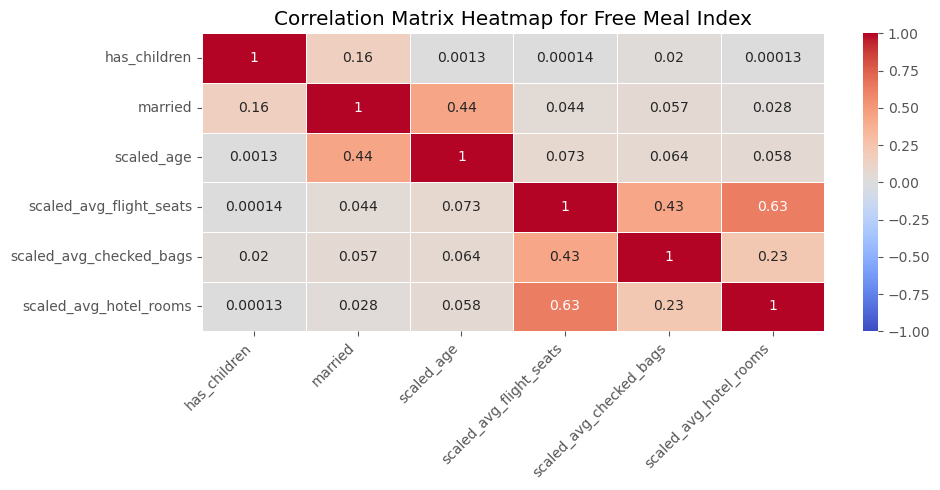

In [19]:
# Define the columns for correlation
free_meal_correlation_columns = ['has_children', 'married','scaled_age', 'scaled_avg_flight_seats', 
                                'scaled_avg_checked_bags', 'scaled_avg_hotel_rooms']

# Compute the correlation matrix
correlation_matrix = cohort_users[free_meal_correlation_columns].corr()

# Set up the figure size
plt.figure(figsize=(10, 5))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Rotate and align x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and display the plot
plt.title("Correlation Matrix Heatmap for Free Meal Index")
plt.tight_layout()
plt.show()

**Analyzing the "Free Meal Index" Correlation Matrix:**

Upon examining the correlation matrix for the "free_meal_index," we made the following observations:

1. **scaled_age** demonstrates a low correlation with all other metrics, indicating that age does not exhibit a strong linear relationship with any of the variables we're considering.

2. **has_children** and **married** also display weak correlations with other metrics. These findings suggest that while having children or being married might hold relevance from a business perspective, they lack strong linear relationships with the other variables. However, their binary nature may influence their correlation magnitudes with other scaled metrics.

3. **scaled_avg_flight_seats** exhibits a moderate correlation with **scaled_avg_checked_bags** and a strong correlation with **scaled_avg_hotel_rooms**. This suggests that users who book more flight seats are also more likely to book more hotel rooms, check more bags, or travel in groups or with their families.

4. **scaled_avg_checked_bags** and **scaled_avg_hotel_rooms** demonstrate a weak to moderate relationship, indicating some connection between the number of checked bags and the number of hotel rooms booked, although it's not exceptionally strong.

**Calculation of the "Free Meal Index":**

Given the strong correlation between **scaled_avg_flight_seats** and **scaled_avg_hotel_rooms**, we will exclude **scaled_avg_hotel_rooms** to avoid redundancy. Typically, unless we have compelling reasons to do otherwise, we would employ uniform scaling, such as 0.25 for each variable, in the calculation of the "Free Meal Index."

In [20]:
# Define the weights for each feature
weights = {
    'scaled_age': 0.25,
    'scaled_avg_flight_seats': 0.25,
    'scaled_avg_hotel_rooms': 0.25,
    'scaled_avg_checked_bags': 0.25
}

# Initialize the free_meal_index column to 0
cohort_users['free_meal_index'] = 0

# Calculate the free_meal_index using the weighted average
for column, weight in weights.items():
    cohort_users['free_meal_index'] += cohort_users[column] * weight

<u>**2. Free Checked Bags:**</u>

**Travelers Covering Long Distances**:
Travelers embarking on extensive journeys often stay at their destinations for extended periods. This necessitates packing a more extensive array of items to accommodate various situations and potentially diverse climates. These travelers may also carry gifts or souvenirs from their destinations.

**Families and Married Couples**:
Families, including couples traveling on honeymoon trips, often have additional luggage requirements. This includes items like strollers, toys, or honeymoon-related items, which contribute to the need for extra checked bags.

**Travelers Booking Round Trips**:
Travelers who opt for round-trip bookings typically prioritize convenience and predictability in their journeys. Offering free checked bags aligns with this mindset, providing a hassle-free experience by eliminating potential additional costs and decisions regarding luggage for both outbound and return flights.

**Relevant Metrics:** avg_stay_duration_day, avg_distance_flown_km, has_children, married, avg_checked_bags, and round_trips_proportion.

These metrics enable us to identify customers who are more likely to appreciate the "Free Checked Bags" perk, allowing us to refine our segmentation strategy accordingly.

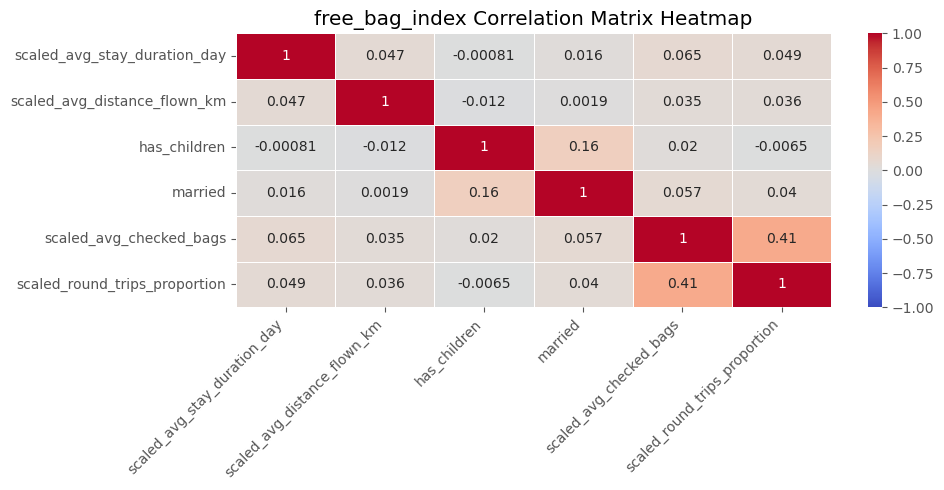

In [21]:
# Defining the correlation_columns list
free_bag_correlation_columns = ['scaled_avg_stay_duration_day', 'scaled_avg_distance_flown_km', 
                                'has_children', 'married', 'scaled_avg_checked_bags', 'scaled_round_trips_proportion']
    

# Compute the correlation matrix for the free_bag_index
correlation_matrix = cohort_users[free_bag_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_bag_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "Free Bag Index" Correlation Matrix:**

Among the correlations observed, the relationship between **scaled_avg_checked_bag** and **round_trip_proportion** emerges as the most robust and carries notable business significance.

While many of the other correlations appear weak, it's worth noting that they could still hold significance within the context of our business objectives. Even with relatively weak correlations, **has_children** remains an essential metric due to its relevance in our business context.

For the calculation of the index, a weighted average approach is a suitable choice. Given the absence of strong correlations between metrics, we will opt for uniform scaling, assigning a weight of 0.25 to each core metric and 0.125 to weaker metrics **married** and **has_children**. This ensures a balanced and equitable contribution from each variable in the computation of the index.

In [22]:
# Define the weights for each feature
weights = {
    'scaled_avg_stay_duration_day': 0.25,
    'scaled_avg_distance_flown_km': 0.25,
    'married': 0.125,
    'has_children': 0.125,
    'scaled_avg_checked_bags': 0.25,
    'scaled_round_trips_proportion': 0.25
}


# Calculate the free_bag_index using the weighted average
cohort_users['free_bag_index'] = 0  # initialize the index column to 0

for column, weight in weights.items():
    cohort_users['free_bag_index'] += cohort_users[column] * weight

<u>**3. No Cancellation Fees:**</u>

**Uncertain Travelers**:
Travelers who are uncertain about their plans, or those who book well in advance, may highly value the "No Cancellation Fees" perk. This offers them the flexibility to make changes to their reservations without the worry of incurring additional costs.

**Travelers with a High Number of Cancelled Trips**:
Travelers who have a history of frequently canceling their trips are also likely to appreciate the flexibility provided by the "No Cancellation Fees" perk. It enables them to make future bookings without the burden of potential cancellation charges.

**Relevant Metrics:** avg_booking_departure_gap_days, scaled_weekend_trip_proportion, discounted_hotel_proportion and cancellation_proportion.

These metrics allow us to identify customers who are more likely to benefit from the "No Cancellation Fees" perk, allowing us to tailor our segmentation strategy accordingly.

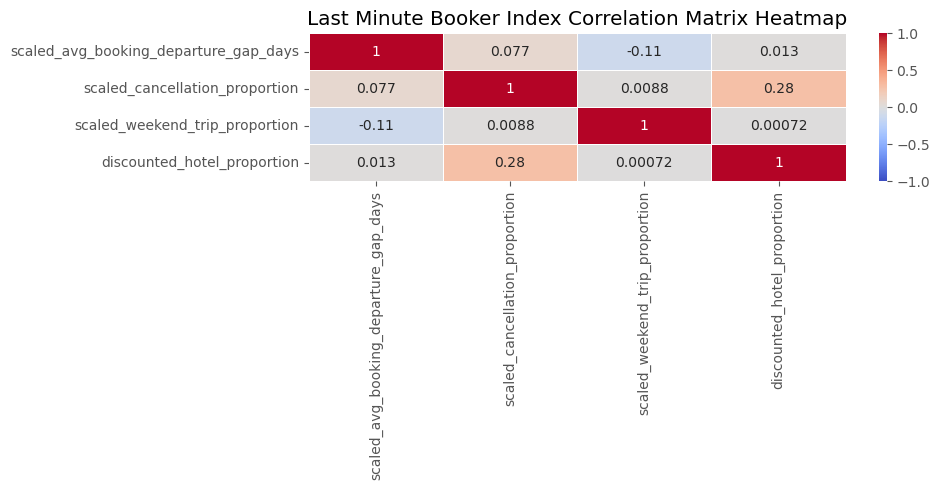

In [23]:
# Define the columns for correlation analysis
last_min_correlation_columns = [
    'scaled_avg_booking_departure_gap_days', 
    'scaled_cancellation_proportion', 
    'scaled_weekend_trip_proportion', 
    'discounted_hotel_proportion'
]

# Compute the correlation matrix for the last_min_booker_index
scaled_correlation_matrix = cohort_users[last_min_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(
    scaled_correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    vmin=-1, 
    vmax=1, 
    linewidths=0.5
)

# Set the title and show the plot
plt.title("Last Minute Booker Index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "Last-Minute Booker Index" Correlation Matrix:**

There is weak correlation across the four columns, with the only notable comment across discounted_hotel_proportion and scale_cancellation_proportion 0.28, which suggests users look for last minute opportunities for greater levels of discounts and bargains.

Our analysis highlights two distinct user behavior patterns:

1. **Planning in Advance**: Users with longer average booking departure gaps tend to be meticulous planners, organizing their trips well in advance. This behavior may indicate a reduced likelihood of booking cancellations, as their travel plans appear more concrete and committed.

2. **Low Cancellation Propensity**: Users with lower cancellation proportions demonstrate a lower inclination to cancel their bookings. This suggests a stronger dedication to their travel plans and a higher likelihood of following through with their reservations.

Given these columns are already scaled, we can directly incorporate them into our index calculation using a weighted average method. This approach allows us to leverage these valuable metrics to assess the propensity for last-minute bookings more effectively.

In [24]:
# Define weights
w1 = 0.25  # Weight for scaled_cancellation_proportion
w2 = 0.25  # Weight for scaled_avg_booking_departure_gap_days
w3 = 0.25  # Weight for scaled_weekend_trip_proportion
w4 = 0.25  # Weight for discounted_hotel_proportion

# Calculate the last_min_booker_index using the weighted average
max_gap = cohort_users['scaled_avg_booking_departure_gap_days'].max()

cohort_users['last_min_booker_index'] = w1 * cohort_users['scaled_cancellation_proportion'] + w2 * (max_gap - cohort_users['scaled_avg_booking_departure_gap_days']) + w3 * cohort_users['scaled_weekend_trip_proportion'] + w4 * cohort_users['discounted_hotel_proportion']

<u>**4. Exclusive Discounts:**</u>

The concept of exclusive discounts may appear slightly less straightforward compared to our other perks. Based on insights from the Marketing Manager, we are targeting price-sensitive customers.

Relevant Metrics:

1. **Conversion Rate**: A low conversion rate suggests a reluctance to make purchases unless offered at a sufficiently low price.
2. **Average Session Duration (in minutes)** and **Average Page Clicks**: Longer values in these metrics may signify behavior characteristic of bargain-hunting, where customers extensively browse and research in search of the best deals.
3. **Average Flight Discount Amount**, **Discounted Flight Proportion**, **Average Hotel Discount Amount**, and **Discounted Hotel Proportion**: These metrics provide insights into the extent to which customers avail discounts on flights and hotel bookings.

**Metrics to Calculate:**

1. **Bargain Hunter Index**: This index will help identify customers with a strong inclination toward seeking bargains and exclusive discounts.
2. **Average Dollar Saved per Kilometer**: This metric quantifies the amount saved per kilometer traveled, providing an additional perspective on cost-conscious behavior.

By examining these metrics and calculating the Bargain Hunter Index and Average Dollar Saved per Kilometer, we can pinpoint price-sensitive customers more effectively, allowing us to tailor our exclusive discounts to their preferences.

In [25]:
# Calculate the average_dollar_saved_per_kilometer metric 
cohort_users['avg_usd_saved_per_km'] = round((cohort_users['avg_flight_discount_amount'] * cohort_users['avg_flight_price_usd']) / cohort_users['avg_distance_flown_km'], 2)

# Initialize the StandardScaler to scale the new metric
scaler = StandardScaler()

# Reshape the data to a 2D array-like structure as StandardScaler expects
# Each row corresponds to a sample and each column corresponds to a feature
scaled_data = cohort_users['avg_usd_saved_per_km'].values.reshape(-1, 1)

# Apply scaling and create a new column with suffix "_scaled"
scaled_data = scaler.fit_transform(scaled_data)
cohort_users['scaled_avg_usd_saved_per_km'] = scaled_data.round(2)

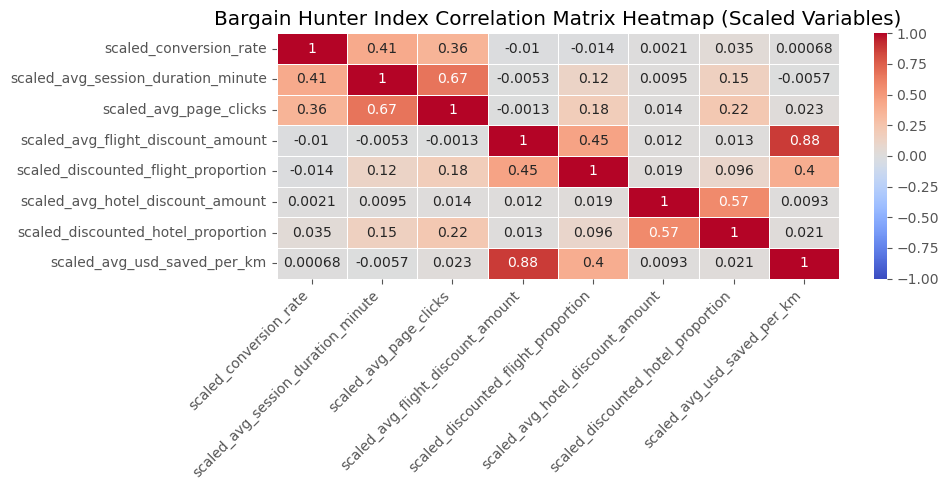

In [26]:
# Define the correlation_columns list for the Bargain Hunter Index
bargain_correlation_columns = [
    'scaled_conversion_rate',
    'scaled_avg_session_duration_minute',
    'scaled_avg_page_clicks',
    'scaled_avg_flight_discount_amount',
    'scaled_discounted_flight_proportion',
    'scaled_avg_hotel_discount_amount',
    'scaled_discounted_hotel_proportion',
    'scaled_avg_usd_saved_per_km'
]

# Compute the correlation matrix for the Bargain Hunter Index relevant metrics using the scaled columns
scaled_correlation_matrix = cohort_users[bargain_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Bargain Hunter Index Correlation Matrix Heatmap (Scaled Variables)")
plt.tight_layout()
plt.show()

**Observations from the Bargin Hunter Index Correlation Matrix:**

1. **Scaled Conversion Rate** exhibits moderate positive correlations with **Scaled Average Session Duration (in minutes)** and **Scaled Average Page Clicks**. This suggests that customers who spend more time on the platform and engage in more page clicks tend to convert less frequently, indicating a higher level of price sensitivity. However, the correlations between **Scaled Conversion Rate** and the other features are all very weak, indicating that these direct price-related features may not individually explain conversion behavior effectively.

2. There exists a strong correlation between **Scaled Average Session Duration (in minutes)** and **Scaled Average Page Clicks**, implying that users who spend more time on the site also tend to click on more pages.

3. Among all the price-related features, the strongest correlation is between **Scaled Average Flight Discount Amount** and **Scaled Average USD Saved per Kilometer**. This suggests that customers who receive higher flight discounts also tend to save more per kilometer traveled, which is expected as **Scaled Average USD Saved per Kilometer** is derived from **Scaled Average Flight Discount Amount**. Therefore, we will exclude **Average Flight Discount Amount** from the index calculation.

4. **Scaled Average Page Clicks** exhibits moderate positive correlations with **Scaled Discounted Flight Proportion** and **Scaled Discounted Hotel Proportion**, indicating that customers who engage in more page clicks may actively be searching for discounts.

For the calculation of the Bargain Hunting Index, we will represent it as a weighted average of the provided metrics. Due to the strong correlation between **Scaled Average Flight Discount Amount** and **Scaled Average USD Saved per Kilometer**, we will exclude the former (as the latter is a product of the former). Additionally, we will retain **Scaled Discounted Hotel Proportion** and remove **Scaled Average Session Duration (in minutes)** while retaining **Scaled Average Page Clicks**. This refinement allows us to create a more effective index for identifying customers with strong bargain-hunting tendencies.

In [27]:
# Define the weights for each feature
weights = {
    'scaled_conversion_rate': 0.2,
    'scaled_avg_page_clicks': 0.2,
    'scaled_discounted_flight_proportion': 0.2,
    'scaled_discounted_hotel_proportion': 0.2,
    'scaled_avg_usd_saved_per_km': 0.2
}

# Calculate the bargain_hunting_index for each row
cohort_users['bargain_hunting_index'] = 0

for column, weight in weights.items():
    # Invert the value for 'conversion_rate' column
    value = (1 - cohort_users[column]) if column == 'scaled_conversion_rate' else cohort_users[column]
    cohort_users['bargain_hunting_index'] += weight * value

<u>**5. 1-Night Free Hotel with a Flight:**</u>

**Frequent Flyers, Especially Round-Trip Travelers**:
Frequent flyers, especially those who frequently opt for round-trip bookings, are likely to highly value the inclusion of a free hotel night as it adds significant value to their travel experience.

**Short-Stay and Weekend Getaway Travelers**:
Travelers who often embark on short stays or weekend getaways typically book accommodations for brief periods. For them, the 1-night free hotel perk can be particularly enticing, as it substantially reduces their overall accommodation expenses.

**Relevant Metrics:** total_flights_booked, weekend_trip_proportion, round_trips_proportion, and total_hotels_booked.

These metrics enable us to identify customers who are more likely to appreciate the "1-Night Free Hotel with a Flight" perk, allowing us to tailor our segmentation strategy accordingly.

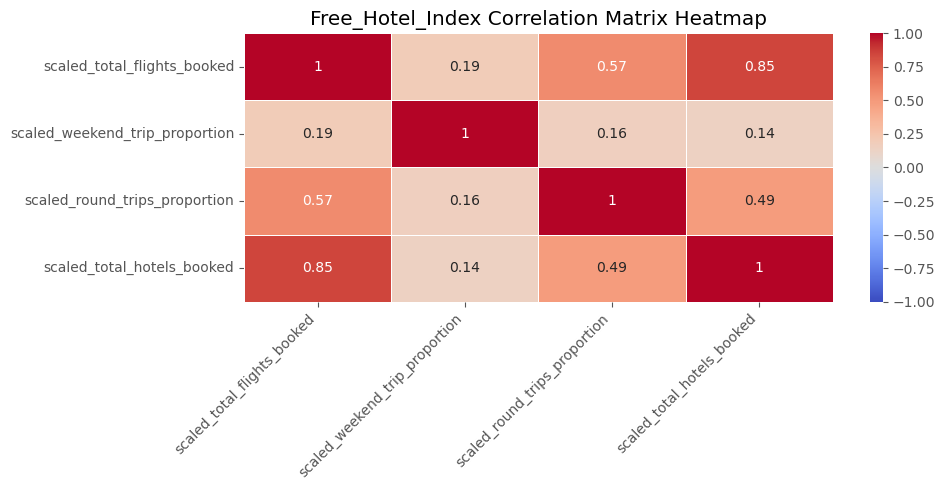

In [28]:
# Define the correlation_columns list
hotel_correlation_columns = [
    'scaled_total_flights_booked',
    'scaled_weekend_trip_proportion',
    'scaled_round_trips_proportion',
    'scaled_total_hotels_booked'
]

# Compute the correlation matrix for the Free_Hotel_Index
correlation_matrix = cohort_users[hotel_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Free_Hotel_Index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "Free Hotel Index" Correlation Matrix:**

1. **Scaled Total Flights Booked** exhibits a strong correlation with **Scaled Total Hotels Booked**, which is logical as frequent flyers are more likely to book hotels frequently. Additionally, it demonstrates a moderate correlation with **Scaled Round Trips Proportion**, indicating that frequent flyers often prefer round-trip bookings.

2. **Scaled Weekend Trip Proportion** displays weak correlations with the other metrics, suggesting it may not be a significant factor in this perk's context.

3. **Scaled Round Trips Proportion** shows a moderate correlation with **Scaled Total Flights Booked** and **Scaled Total Hotels Booked**, indicating that travelers who frequently book round trips also tend to book flights and hotels together.

The robust correlation between **Scaled Total Flights Booked** and **Scaled Total Hotels Booked** provides valuable insights into the booking patterns of frequent flyers, a crucial consideration for the "1-Night Free Hotel with a Flight" perk.

The moderate correlations involving **Scaled Round Trips Proportion** underscore the relevance of round trip bookings within the context of this perk.

For the metric calculation, a weighted average approach will be employed. As in previous cases, we will exclude **Scaled Total Flights Booked** and **Scaled Round Trips Proportion**, refining our index to effectively identify customers who are likely to appreciate the "1-Night Free Hotel with a Flight" perk.

In [29]:
# Define the weights for each feature
weights = {
    'scaled_weekend_trip_proportion': 0.50,
    'scaled_total_hotels_booked': 0.50
}

# Calculate the free_hotel_index for each row
cohort_users['free_hotel_index'] = 0

for column, weight in weights.items():
    cohort_users['free_hotel_index'] += cohort_users[column] * weight

# Verify the creation of the 'Free_Hotel_Index' for each user
cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,age_group,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,avg_booking_departure_gap_days,has_booked_flight,has_booked_hotel,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,free_meal_index,free_bag_index,last_min_booker_index,avg_usd_saved_per_km,scaled_avg_usd_saved_per_km,bargain_hunting_index,free_hotel_index
11,153982,2022-04-19,43,F,False,True,canada,toronto,35-49,11,2.23,26.00,5,0.45,0.2,0.20,5,1.0,1139.94,0.00,0.15,1.00,0.88,6439.29,5,255.38,0.15,0.23,1.00,6.00,True,97.93,True,True,0.21,3.72,0.77,1.07,1.37,0.60,1.41,2.49,0.55,1.65,0.5,2.30,-1.31,-0.21,-0.04,0.87,4.27,1.63,1.17,1.09,0.78,-0.18,1.04,0.2150,1.7950,1.7025,0.00,-1.15,0.178,1.520
16,174997,2022-05-10,30,F,False,False,usa,grand rapids,19-34,9,0.91,39.73,3,0.33,0.0,0.33,3,1.0,1855.78,0.00,0.18,1.67,0.67,5327.80,3,112.00,0.09,0.55,1.00,1.50,True,91.23,True,True,-0.89,0.87,-0.75,2.70,0.11,-0.04,-0.38,4.26,0.48,0.37,0.5,4.68,-1.31,0.01,1.26,0.40,3.17,0.30,-0.89,0.21,3.42,-0.18,-0.68,0.1475,0.8475,1.7950,0.00,-1.15,1.204,-0.040
18,181157,2022-05-15,51,F,True,False,usa,houston,50-64,10,1.83,50.25,4,0.40,0.0,0.25,4,1.0,2300.71,0.18,0.33,2.00,1.00,7110.11,4,129.57,0.15,0.25,1.43,7.14,True,113.20,True,True,0.89,2.29,0.31,3.96,0.74,0.33,-0.38,3.17,0.70,1.01,0.5,6.16,0.83,1.14,1.90,1.15,4.93,0.97,-0.64,1.09,0.94,0.74,1.48,1.1700,2.1400,1.3925,0.06,1.81,1.704,0.295
21,189676,2022-05-23,34,F,False,True,usa,fort worth,19-34,10,1.08,44.25,3,0.30,0.0,0.33,2,1.0,307.05,0.18,0.42,1.40,0.40,781.67,3,180.50,0.00,0.17,2.00,9.00,True,159.69,True,True,-0.55,2.29,-0.55,3.24,0.11,-0.20,-0.38,4.26,1.17,-0.26,0.5,-0.46,0.83,1.81,0.74,-0.21,-1.31,0.30,0.09,-1.11,0.28,1.95,2.19,0.4825,0.4175,1.5275,0.07,2.31,1.768,-0.040
33,226367,2022-06-25,41,F,False,False,usa,washington,35-49,9,1.22,13.89,4,0.44,0.0,0.00,4,1.0,1345.75,0.05,0.11,1.75,1.00,3388.10,3,253.00,0.00,0.00,1.33,1.67,True,47.70,True,True,0.04,0.87,-0.39,-0.38,0.74,0.55,-0.38,-0.22,0.05,1.01,0.5,2.99,-0.72,-0.51,1.42,1.15,1.26,0.30,1.13,-1.11,-1.12,0.52,-0.62,0.7825,0.5725,0.6450,0.02,-0.16,-0.344,-0.040


# Segmentation

In [30]:
# Select only the index columns
perks_indexes_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 
                   'bargain_hunting_index', 'free_hotel_index']

# Create a DataFrame containing only the index columns
perk_indexes = cohort_users[perks_indexes_columns]

# Display the first few rows of the index DataFrame
perk_indexes.head()

,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index
11,0.2150,1.7950,1.7025,0.178,1.520
16,0.1475,0.8475,1.7950,1.204,-0.040
18,1.1700,2.1400,1.3925,1.704,0.295
21,0.4825,0.4175,1.5275,1.768,-0.040
33,0.7825,0.5725,0.6450,-0.344,-0.040


In [31]:
perk_indexes.describe()

,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index
count,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000
mean,-0.000050,0.095595,0.839305,0.200054,-0.001847
std,0.659705,0.585306,0.445639,0.494841,0.756912
min,-1.872500,-1.402500,-0.150000,-1.222000,-1.035000
25%,-0.262500,-0.200000,0.747500,-0.141000,-0.705000
50%,0.055000,0.122500,0.777500,0.182000,-0.040000
75%,0.357500,0.422500,0.812500,0.477000,0.295000
max,2.740000,2.755000,3.685000,2.898000,2.975000


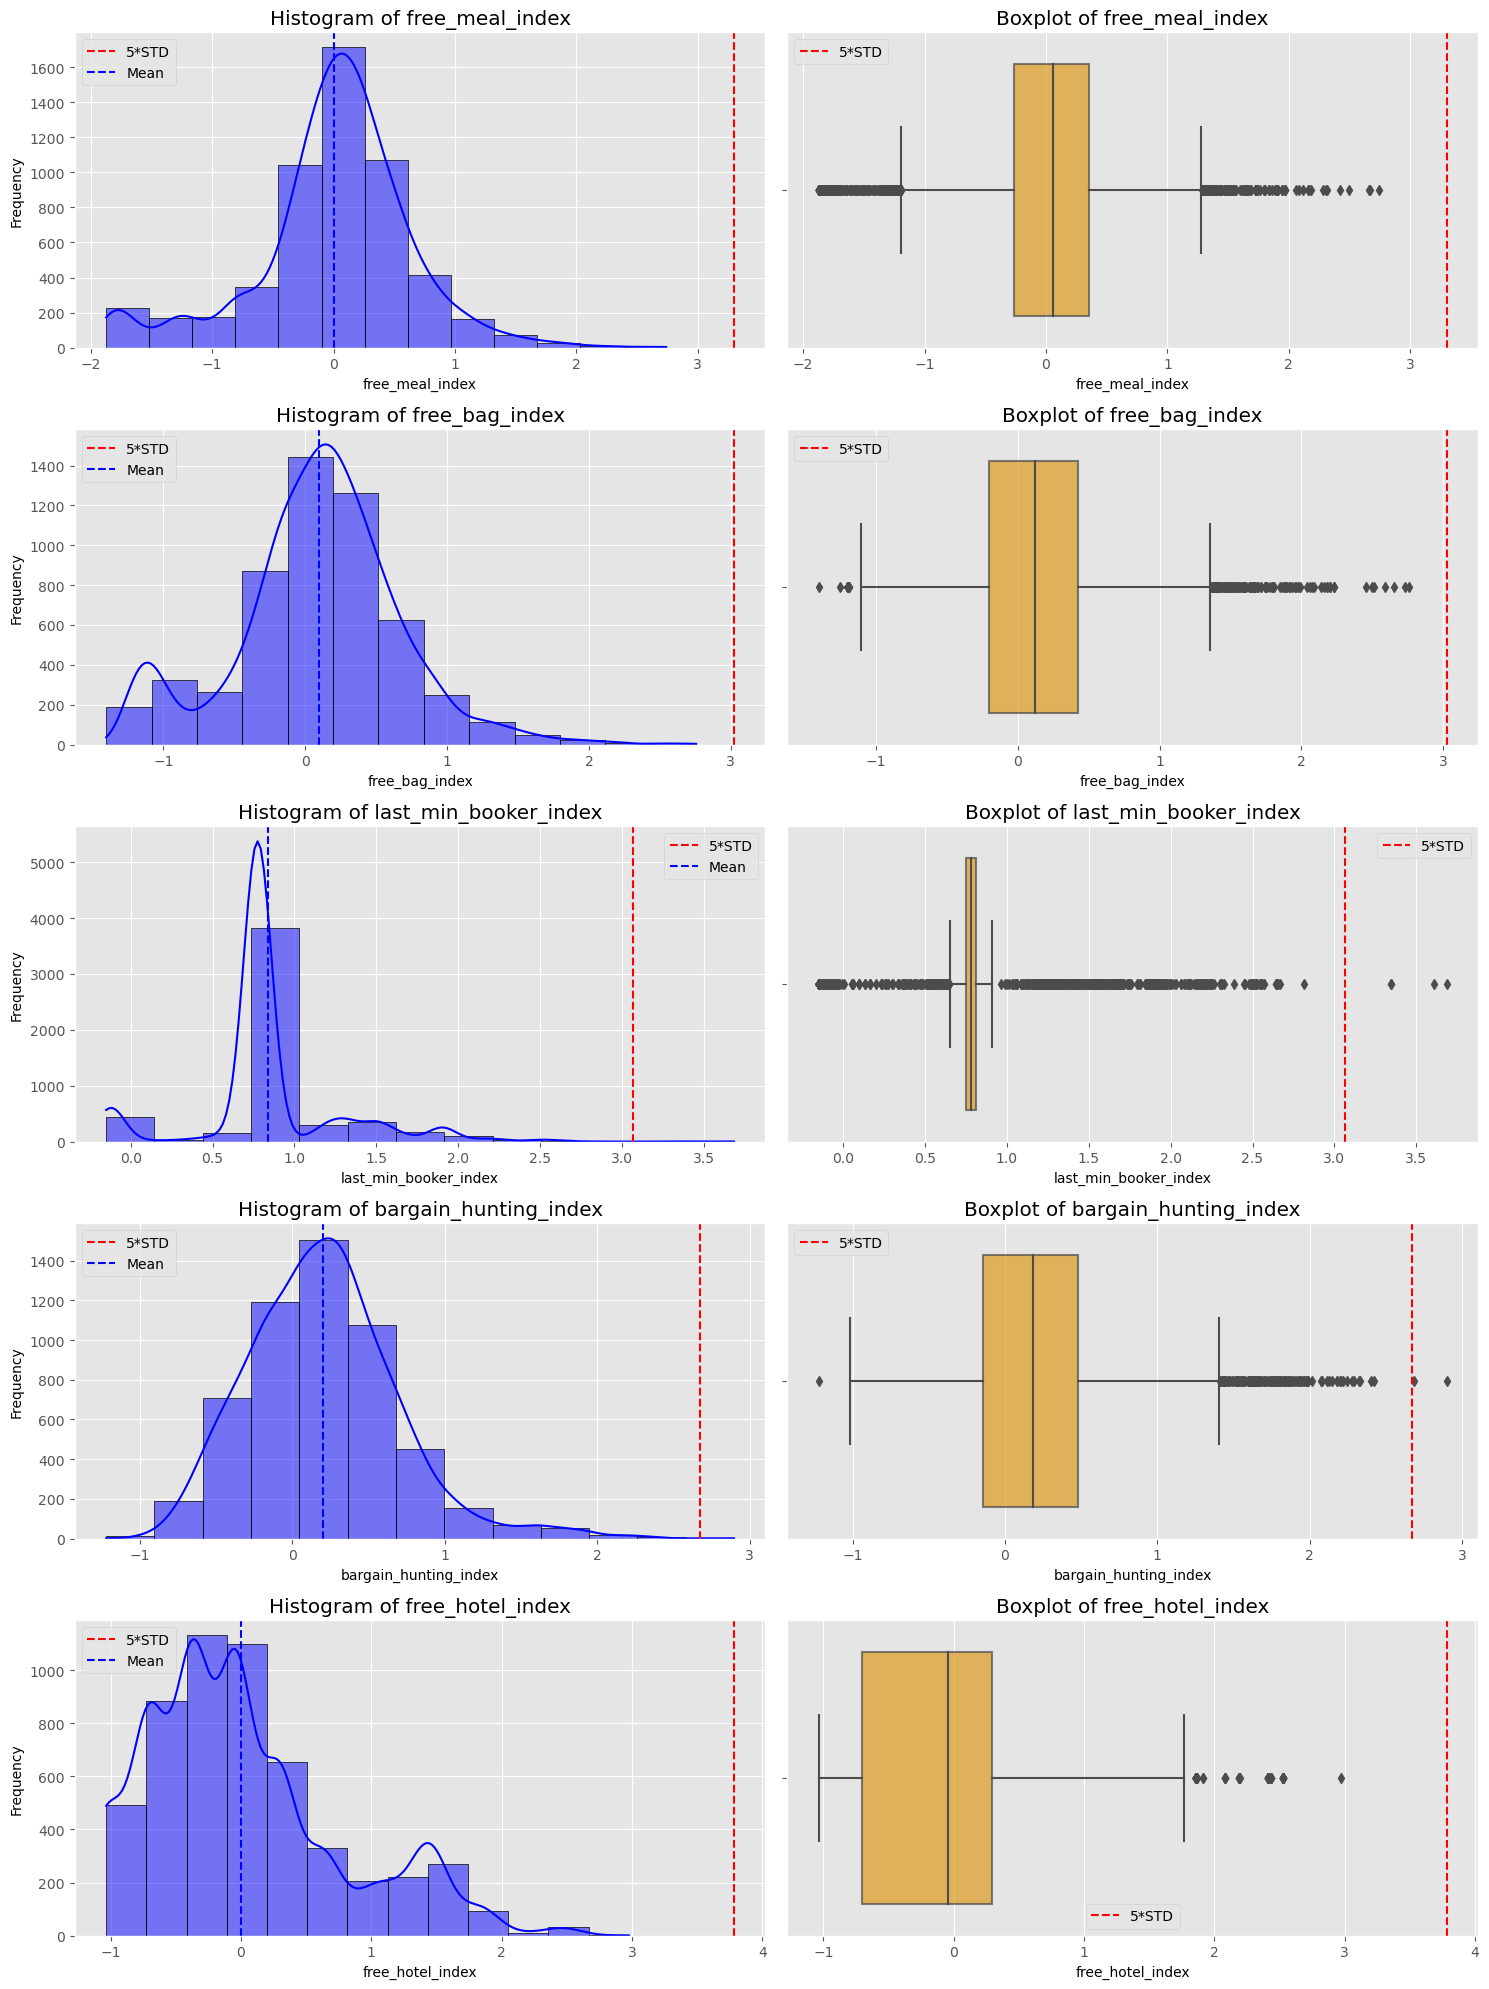

In [32]:
# Set up the figure and axes
fig, axes = plt.subplots(len(perks_indexes_columns), 2, figsize=(15, 4 * len(perks_indexes_columns)))

for i, col in enumerate(perks_indexes_columns):
    # Calculate upper bound
    upper_bound = cohort_users[col].mean() + 5 * cohort_users[col].std()
    mean = cohort_users[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(cohort_users[col])) + 1)  # Sturges' formula
    sns.histplot(cohort_users[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black', color='blue', 
                 line_kws={'color': 'green'})  # Use line_kws to set the KDE line color
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].axvline(upper_bound, color='red', linestyle='--', label=f'5*STD')
    axes[i, 0].axvline(mean, color='blue', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=cohort_users[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7), color='orange')
    axes[i, 1].axvline(upper_bound, color='red', linestyle='--', label=f'5*STD')
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

<u>**Ranking the Perk Indexes:**</u>

Now that we have computed the perk indexes for each customer, the following steps will be performed for each perk:

1. Arrange the dataset in descending order based on the respective perk index.
2. Assign ranks, beginning from 1 and extending up to N, where N represents the total number of customers.

The Perk Index Ranks for Each Customer:

- **Free Meal Index Rank**
- **Free Bag Index Rank**
- **Last-Minute Booker Index Rank**
- **Bargain Hunting Index Rank**
- **Free Hotel Index Rank**

These ranks commence from 1, signifying the highest alignment of a specific customer with a particular perk, and progress up to N, encompassing the total customer count.

Identifying the Minimum Rank Perk for Each Customer:

The subsequent stage involves determining which perk attains the lowest rank for each individual customer. The perk assigned the lowest rank will be the one that best corresponds to the customer's preferences. We will now proceed with this phase.

In [33]:
# Initialize an empty DataFrame to store the ranks, setting user_id as the index for easier alignment
rank_df = cohort_users[['user_id']].copy()
rank_df.set_index('user_id', inplace=True)

# List of perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Loop through each perk index to sort and rank
for perk in perk_indexes:
    # Sort by the perk index and reset the index
    sorted_data = cohort_users.sort_values(by=[perk], ascending=False).reset_index(drop=True)
    
    # Assign rank starting from 1 to N
    sorted_data[f'{perk}_rank'] = sorted_data.index + 1
    
    # Align the ranks with the original user_id and store them in the rank DataFrame
    rank_df[f'{perk}_rank'] = sorted_data.set_index('user_id')[f'{perk}_rank']

# Reset the index for the final DataFrame
rank_df.reset_index(inplace=True)
    
# Display the first few rows of the rank DataFrame
rank_df.head()

,user_id,free_meal_index_rank,free_bag_index_rank,last_min_booker_index_rank,bargain_hunting_index_rank,free_hotel_index_rank
0,153982,1950,37,278,2723,254
1,174997,2240,433,267,180,2043
2,181157,164,15,579,66,1786
3,189676,988,1385,402,57,2178
4,226367,440,917,4876,4728,2240


In [34]:
# Calculate the minimum rank for each customer and the corresponding perk index
rank_df['min_rank'] = rank_df.iloc[:, 1:].min(axis=1)
rank_df['best_index'] = rank_df.iloc[:, 1:].idxmin(axis=1).str.replace('_rank', '')

# Display the first few rows of the rank DataFrame with the min rank and best perk
rank_df.head(10)

,user_id,free_meal_index_rank,free_bag_index_rank,last_min_booker_index_rank,bargain_hunting_index_rank,free_hotel_index_rank,min_rank,best_index
0,153982,1950,37,278,2723,254,37,free_bag_index
1,174997,2240,433,267,180,2043,180,bargain_hunting_index
2,181157,164,15,579,66,1786,15,free_bag_index
3,189676,988,1385,402,57,2178,57,bargain_hunting_index
4,226367,440,917,4876,4728,2240,440,free_meal_index
5,228872,284,1359,4123,1171,1799,284,free_meal_index
6,229108,5072,4601,63,49,4631,49,bargain_hunting_index
7,229330,986,3995,3366,5177,1072,986,free_meal_index
8,249521,560,220,3570,931,1075,220,free_bag_index
9,264470,2989,1466,3520,2914,3062,1466,free_bag_index


**Determining the Optimal Perk:**

We have successfully ascertained the perk associated with the lowest rank for each customer. Within the rank_df DataFrame, two new columns have been introduced:

1. **min_rank**: Signifies the minimum rank across all perks for each individual customer.
2. **best_index**: Indicates the specific perk corresponding to the minimum rank.

In essence, the perk denoted in the **best_perk** column is the one that most closely aligns with each customer's preferences within the context of fuzzy segmentation.

In [35]:
# Count the number of customers most inclined towards each perk
perk_distribution = rank_df['best_index'].value_counts().reset_index()
perk_distribution.columns = ['Best Index', 'Number of Customers']

# Create a dictionary to map the index names to the perk names
perk_names = {
    'free_meal_index': 'Free hotel meal',
    'free_bag_index': 'Free checked bag',
    'last_min_booker_index': 'No cancellation fees',
    'bargain_hunting_index': 'Exclusive discounts',
    'free_hotel_index': '1-night free hotel with a flight'
}

# Add a new column for the perk names
perk_distribution['Perk Name'] = perk_distribution['Best Index'].map(perk_names)

# Reorder columns for better readability
perk_distribution = perk_distribution[['Best Index', 'Perk Name', 'Number of Customers']]

# Display the updated distribution with perk names
perk_distribution

,Best Index,Perk Name,Number of Customers
0,bargain_hunting_index,Exclusive discounts,1480
1,free_hotel_index,1-night free hotel with a flight,1258
2,free_bag_index,Free checked bag,1084
3,free_meal_index,Free hotel meal,977
4,last_min_booker_index,No cancellation fees,628


**Summarizing the Segmentation:**

To conclude our segmentation analysis, we will generate a summary by quantifying the number of customers who exhibit the strongest inclination toward each perk. This summary will provide insights into the distribution of perks among our customer base.

In [36]:
# Map the index names to the more descriptive perk names for segment labels
rank_df['segment_label'] = rank_df['best_index'].map(perk_names)

# Drop the 'best_index' column as we now have 'segment_label'
rank_df.drop(columns=['best_index'], inplace=True)

# Perform the join based on user_id
cohort_users = cohort_users.merge(rank_df[['user_id', 'segment_label']], on='user_id', how='left')

cohort_users.head(10)

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,age_group,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,avg_booking_departure_gap_days,has_booked_flight,has_booked_hotel,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,free_meal_index,free_bag_index,last_min_booker_index,avg_usd_saved_per_km,scaled_avg_usd_saved_per_km,bargain_hunting_index,free_hotel_index,segment_label
0,153982,2022-04-19,43,F,False,True,canada,toronto,35-49,11,2.23,26.00,5,0.45,0.2,0.20,5,1.0,1139.94,0.00,0.15,1.00,0.88,6439.29,5,255.38,0.15,0.23,1.00,6.00,True,97.93,True,True,0.21,3.72,0.77,1.07,1.37,0.60,1.41,2.49,0.55,1.65,0.5,2.30,-1.31,-0.21,-0.04,0.87,4.27,1.63,1.17,1.09,0.78,-0.18,1.04,2.150000e-01,1.7950,1.7025,0.00,-1.15,0.178,1.520,Free checked bag
1,174997,2022-05-10,30,F,False,False,usa,grand rapids,19-34,9,0.91,39.73,3,0.33,0.0,0.33,3,1.0,1855.78,0.00,0.18,1.67,0.67,5327.80,3,112.00,0.09,0.55,1.00,1.50,True,91.23,True,True,-0.89,0.87,-0.75,2.70,0.11,-0.04,-0.38,4.26,0.48,0.37,0.5,4.68,-1.31,0.01,1.26,0.40,3.17,0.30,-0.89,0.21,3.42,-0.18,-0.68,1.475000e-01,0.8475,1.7950,0.00,-1.15,1.204,-0.040,Exclusive discounts
2,181157,2022-05-15,51,F,True,False,usa,houston,50-64,10,1.83,50.25,4,0.40,0.0,0.25,4,1.0,2300.71,0.18,0.33,2.00,1.00,7110.11,4,129.57,0.15,0.25,1.43,7.14,True,113.20,True,True,0.89,2.29,0.31,3.96,0.74,0.33,-0.38,3.17,0.70,1.01,0.5,6.16,0.83,1.14,1.90,1.15,4.93,0.97,-0.64,1.09,0.94,0.74,1.48,1.170000e+00,2.1400,1.3925,0.06,1.81,1.704,0.295,Free checked bag
3,189676,2022-05-23,34,F,False,True,usa,fort worth,19-34,10,1.08,44.25,3,0.30,0.0,0.33,2,1.0,307.05,0.18,0.42,1.40,0.40,781.67,3,180.50,0.00,0.17,2.00,9.00,True,159.69,True,True,-0.55,2.29,-0.55,3.24,0.11,-0.20,-0.38,4.26,1.17,-0.26,0.5,-0.46,0.83,1.81,0.74,-0.21,-1.31,0.30,0.09,-1.11,0.28,1.95,2.19,4.825000e-01,0.4175,1.5275,0.07,2.31,1.768,-0.040,Exclusive discounts
4,226367,2022-06-25,41,F,False,False,usa,washington,35-49,9,1.22,13.89,4,0.44,0.0,0.00,4,1.0,1345.75,0.05,0.11,1.75,1.00,3388.10,3,253.00,0.00,0.00,1.33,1.67,True,47.70,True,True,0.04,0.87,-0.39,-0.38,0.74,0.55,-0.38,-0.22,0.05,1.01,0.5,2.99,-0.72,-0.51,1.42,1.15,1.26,0.30,1.13,-1.11,-1.12,0.52,-0.62,7.825000e-01,0.5725,0.6450,0.02,-0.16,-0.344,-0.040,Free hotel meal
5,228872,2022-06-27,33,M,False,False,usa,san antonio,19-34,11,2.09,21.91,4,0.36,0.0,0.00,3,1.0,326.46,0.33,0.18,2.00,1.00,1480.15,4,87.75,0.00,0.00,1.75,5.00,True,6.85,True,True,-0.64,3.72,0.61,0.58,0.74,0.12,-0.38,-0.22,-0.36,0.37,0.5,-0.40,2.61,0.01,1.90,1.15,-0.62,0.97,-1.24,-1.11,-1.12,1.42,0.66,9.575000e-01,0.4225,0.7475,0.07,2.31,0.532,0.295,Free hotel meal
6,229108,2022-06-27,24,F,False,False,usa,burlington,19-34,9,1.09,49.64,2,0.22,0.0,0.50,2,1.0,390.68,0.20,0.36,1.00,0.00,2351.66,1,163.00,0.10,0.36,0.00,0.00,True,152.84,True,False,-1.40,0.87,-0.54,3.89,-0.52,-0.63,-0.38,6.56,1.10,-0.26,0.5,-0.18,1.06,1.36,-0.04,-1.12,0.24,-1.03,-0.16,0.36,1.85,-2.31,-1.25,-1.217500e+00,-0.4075,2.1675,0.03,0.33,1.812,-0.705,Exclusive discounts
7,229330,2022-06

# Exploratory Data Analysis for Customer Segmentation:

Before proceeding to the final stage and exporting the customer segmentation CSV file, conducting an exploratory data analysis (EDA) is of paramount importance. EDA serves as a critical step in gaining a deeper understanding of the segmentation, validating the data, and ensuring alignment with the proposed perks. Furthermore, it lays the foundation for deriving insights that are substantiated by empirical evidence.

<u>**Distribution of Customers Among Segments:**</u>

To begin, let's create a bar chart to visually depict the distribution of customers across various segments. This visual representation will provide us with a comprehensive overview of the segmentation distribution.

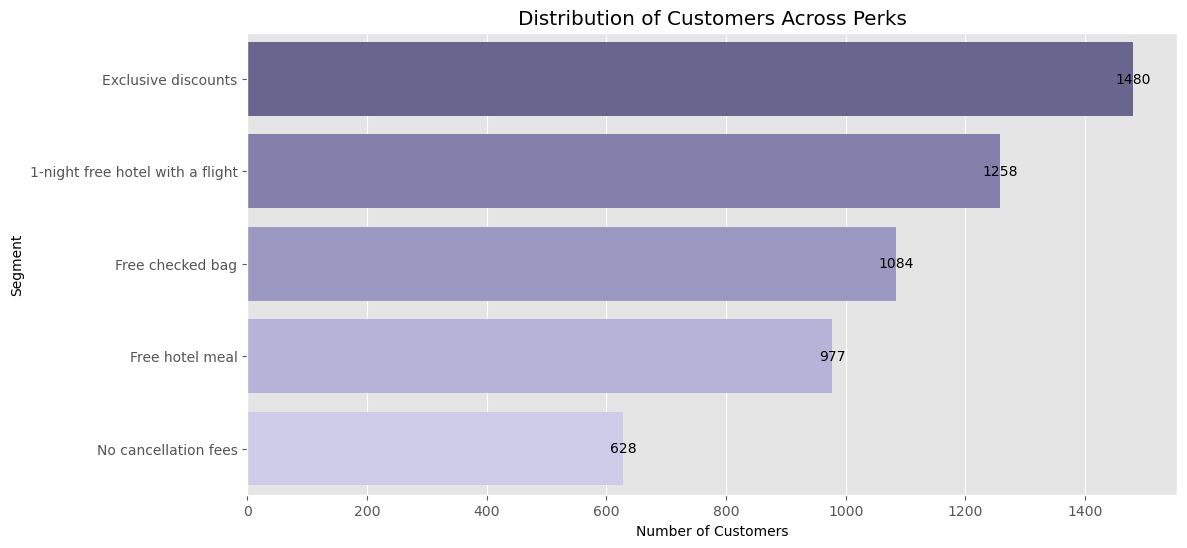

In [37]:
# Count the number of customers in each segment
segment_count = cohort_users['segment_label'].value_counts().reset_index()
segment_count.columns = ['Segment', 'Number of Customers']

# Create a cubehelix color palette with reversed intensity (high to low)
custom_palette = sns.cubehelix_palette(len(segment_count), start=3, rot=0, dark=0.4, light=0.8, reverse=True)

# Plotting the bar chart with the custom color palette
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Customers', y='Segment', data=segment_count, palette=custom_palette)
plt.title('Distribution of Customers Across Perks')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')

# Annotate bars with count values
for index, value in enumerate(segment_count['Number of Customers']):
    plt.text(value, index, str(value), ha='center', va='center', fontsize=10, color='black')

plt.show()

The bar chart depicted above illustrates the customer distribution among various segments, primarily determined by the perks they are most likely to prioritize. These segments can be described as follows:

1. **Exclusive Discounts**: This segment boasts the largest customer count, indicating a substantial portion of our customer base values cost-effectiveness and is inclined towards exclusive discounts.

2. **1-Night Free Hotel with a Flight**: Following closely behind the first segment, this suggests a noteworthy presence of frequent flyers who find the prospect of a complimentary hotel stay appealing.

3. **No Cancellation Fees**: Positioned as the third-largest segment, this indicates that a significant fraction of our customer base places a premium on flexibility regarding booking cancellations.

4. **Free Hotel Meal**: This segment signifies that a considerable number of customers view a complimentary hotel meal as an enticing perk.

5. **Free Checked Bag**: While the smallest of the segments, it is not significantly smaller, revealing that a noteworthy portion of travelers factors in baggage expenses when booking flights. Consequently, they are receptive to a perk that provides free checked bags.

The alignment between this distribution and the proposed perks from the Marketing team underscores the effectiveness of these perk offerings, as each targets a substantial and distinct customer segment.

<u>**Average Age Across Perks:**</u>

Our next step involves visualizing the average age of customers within each segment, allowing us to discern whether specific perks exhibit varying degrees of appeal across different age groups.

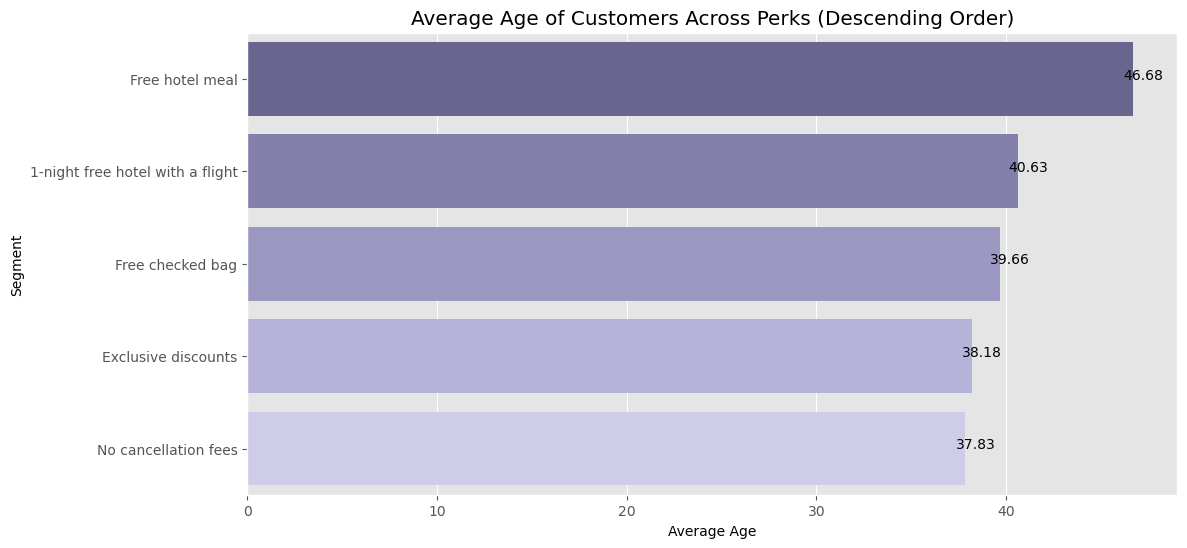

In [38]:
# Calculate the average age for each segment
avg_age_segment = cohort_users.groupby('segment_label')['age'].mean().reset_index()
avg_age_segment.columns = ['Segment', 'Average Age']

# Sort segments by average age in descending order
avg_age_segment = avg_age_segment.sort_values(by='Average Age', ascending=False)

# Create a cubehelix color palette with reversed intensity (high to low)
custom_palette = sns.cubehelix_palette(len(avg_age_segment), start=3, rot=0, dark=0.4, light=0.8, reverse=True)

# Plotting the bar chart for average age with the custom color palette
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Average Age', y='Segment', data=avg_age_segment, palette=custom_palette)

# Annotate the average age of each segment
for index, value in enumerate(avg_age_segment['Average Age']):
    ax.text(value - 0.5, index, str(round(value, 2)))

plt.title('Average Age of Customers Across Perks (Descending Order)')
plt.xlabel('Average Age')
plt.ylabel('Segment')
plt.show()

The bar chart provides an overview of the average age distribution among customers in various segments. Notably, the average ages across all segments closely align with one another.

- **Free Hotel Meal**: Within this segment, the average age is the highest, implying that older customers may be more inclined to appreciate the allure of a complimentary hotel meal. This observation aligns with our earlier utilization of age in the index calculation.

- **1-Night Free Hotel with a Flight**: Following closely, this segment boasts the second-highest average age.

- **No Cancellation Fees and Exclusive Discounts**: These segments exhibit the lowest average ages, hinting that younger customers within these segments might prioritize flexibility in their travel arrangements and seek budget-friendly options.

This insightful data can be harnessed for strategic marketing initiatives and the tailoring of perk offerings to suit specific customer age groups.

<u>**Gender Perk Distribution Analysis**</u>

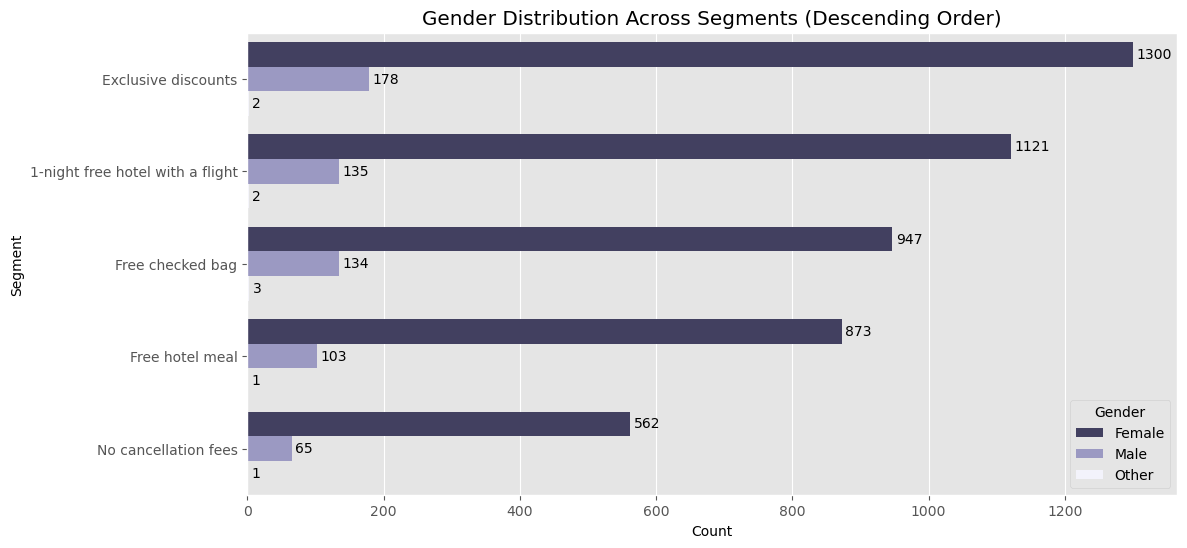

In [39]:
# Calculate the count of each gender in each segment
gender_segment_counts = cohort_users.groupby(['segment_label', 'gender']).size().reset_index(name='Count')

# Sort segments by total count in descending order
sorted_segments = gender_segment_counts.groupby('segment_label')['Count'].sum().sort_values(ascending=False).index
gender_segment_counts['segment_label'] = pd.Categorical(gender_segment_counts['segment_label'], categories=sorted_segments, ordered=True)

# Create a cubehelix color palette with with reversed intensity (high to low)
custom_palette = sns.cubehelix_palette(3, start=0, rot=0, dark=0.25, light=0.95, reverse=True)

# Plotting the bar chart for gender distribution with data labels
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='segment_label', hue='gender', data=gender_segment_counts, palette=custom_palette, errorbar=None)

# Add data labels to the bars (total count for each category)
for p in ax.patches:
    width = p.get_width()
    segment = gender_segment_counts['segment_label'].iloc[int(p.get_y())]
    gender = gender_segment_counts['gender'].iloc[int(p.get_y())]
    count = int(width)
    plt.text(width + 5, p.get_y() + p.get_height() / 2, f"{count}", ha="left", va="center", fontsize=10)

plt.title('Gender Distribution Across Segments (Descending Order)')
plt.xlabel('Count')
plt.ylabel('Segment')
plt.legend(title='Gender', labels=['Female', 'Male', 'Other'])
plt.show()

The gender distribution across the five perks exhibits a consistent pattern: there is a higher representation of females in all perk segments. This observation implies that the proposed perks are more commonly associated with female customers within our dataset.

This gender disparity within the perks may mirror the overall user demographics and presents an opportunity for targeted marketing campaigns or potential adjustments to the perks to resonate with a more balanced audience.

<u>**Top 5 Location Perk Distribution Analysis**</u>

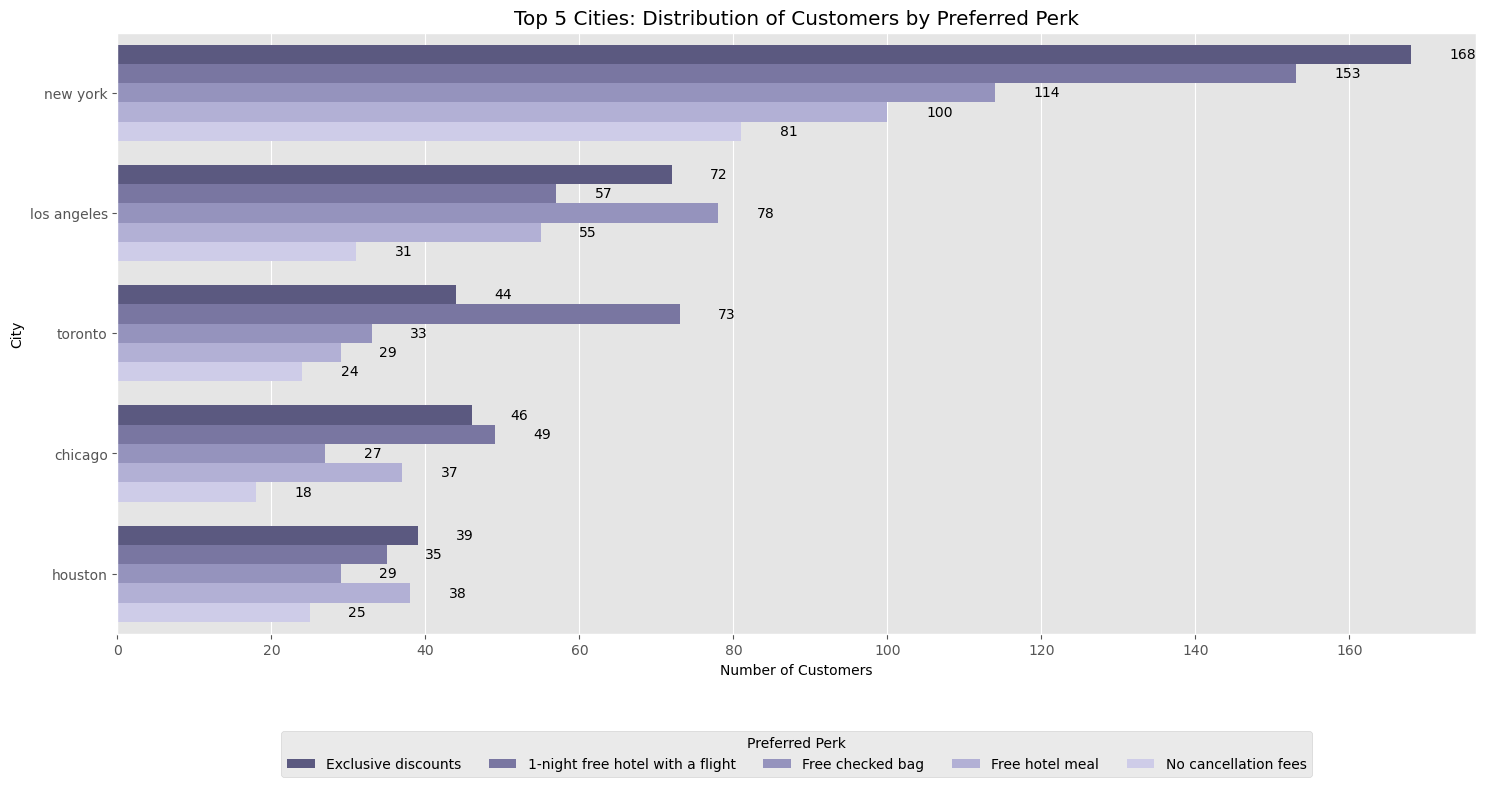

In [41]:
# Plotting the distribution of customers across top 5 cities and their most preferred perk
top_5_cities = cohort_users['home_city'].value_counts().nlargest(5).index.tolist()

# Filter the data to only include the top 5 cities
top_5_cities_data = cohort_users[cohort_users['home_city'].isin(top_5_cities)]

# Create a cubehelix color palette with reversed intensity (high to low)
custom_palette = sns.cubehelix_palette(len(top_5_cities_data['segment_label'].unique()), start=3, rot=0, dark=0.35, light=0.8, reverse=True)

# Create a horizontal bar chart for the top 5 cities
plt.figure(figsize=(15, 8))
ax = sns.countplot(
    data=top_5_cities_data,
    y='home_city',
    hue='segment_label',
    palette=custom_palette,
    order=top_5_cities,
    hue_order=top_5_cities_data['segment_label'].value_counts().index  # Sort by perk frequency
)

plt.title('Top 5 Cities: Distribution of Customers by Preferred Perk')
plt.xlabel('Number of Customers')
plt.ylabel('City')

# Add data labels to each bar in the chart
for p in ax.patches:
    width = p.get_width()
    city = top_5_cities_data['home_city'].iloc[int(p.get_y())]
    count = int(width)
    plt.text(width + 5, p.get_y() + p.get_height() / 2, f"{count}", ha="left", va="center", fontsize=10)

# Place the legend at the bottom of the graph
plt.legend(title='Preferred Perk', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(top_5_cities_data['segment_label'].unique()))

plt.tight_layout()
plt.show()

The horizontal bar chart provides insights into the distribution of customer preferences for the top 5 cities and their preferred perks:

**New York City**: In this city, "1-night Free Hotel with a Flight" emerges as the most favored perk among customers, followed closely by "Exclusive Discounts" and "No Cancellation Fees."

**Toronto**: Similar to New York City, the preferences in Toronto are dominated by "1-night Free Hotel with a Flight" and "Exclusive Discounts." Additionally, "Free Hotel Meal" exhibits a noticeable presence among customers.

**Houston**: In Houston, "Exclusive Discounts" takes the lead as the most preferred perk, followed by "1-night Free Hotel with a Flight" and "Free Hotel Meal."

**Los Angeles**: Los Angeles stands out with a strong preference for "Free Checked Bag," which is the top choice among customers. "1-night Free Hotel with a Flight" also garners significant attention.

**Chicago**: Chicago residents lean towards "1-night Free Hotel with a Flight" as their preferred perk. Interestingly, "No Cancellation Fees" and "Exclusive Discounts" share a nearly equal number of customers, indicating a divided preference for these two perks in the city.

These findings highlight the diversity in perk preferences across different cities, which can be valuable for tailoring marketing strategies and perk offerings to align with local customer interests.

<u>**Distribution of Perk Index Values**</u>

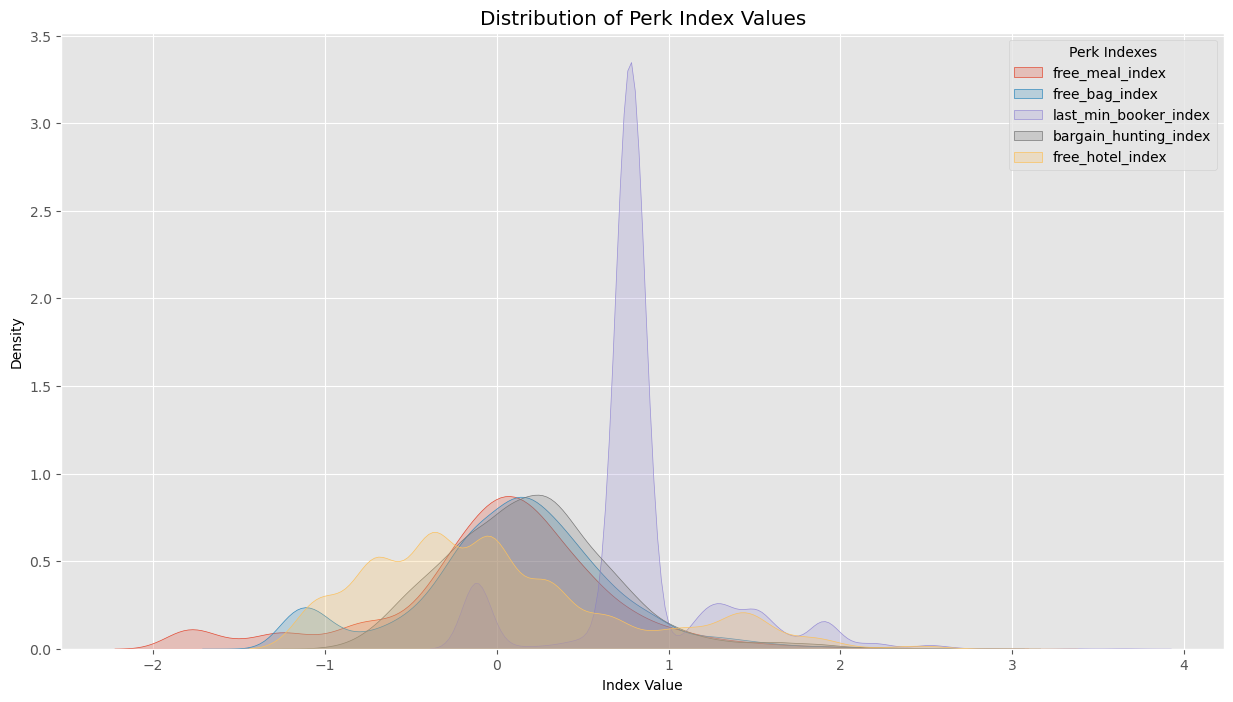

In [43]:
# Select only the columns that contain the indexes
index_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Select data from the index columns
index_data = cohort_users[index_columns]

# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
index_data = index_data.copy()

# Rename the columns with proper names
index_data.rename(columns={
    'Free Meal Index': 'Free Meal Index',
    'Free Bag Index': 'Free Bag Index',
    'Last Minute Booker Index': 'Last Minute Booker Index',
    'Bargain Hunting Index': 'Bargain Hunting Index',
    'Free Hotel Index': 'Free Hotel Index'
}, inplace=True)

# Create a figure for the distribution plot
plt.figure(figsize=(15, 8))

# Define a denser color palette
custom_palette = sns.color_palette("husl", n_colors=len(index_columns))

# Loop through the columns to plot each one
for i, column in enumerate(index_columns):
    sns.kdeplot(index_data[column], label=column, fill=True, color=custom_palette[i])

plt.title('Distribution of Perk Index Values')
plt.xlabel('Index Value')
plt.ylabel('Density')
plt.legend(title='Perk Indexes')
plt.show()

The plot provides a visual representation of the distribution of perk index values for various proposed perks. Each curve signifies the density distribution of a specific index value across all users.

Key Insights:

1. **Index Value Overlap**: Notably, there is a substantial overlap in index values, particularly between the free_meal_index and free_bag_index. This implies that many users exhibit similar index values for different perks, indicating a potential convergence in perk preferences among customers.

2. **Varied Distribution**: Some indexes, such as the last_min_booker_index and free_meal_index, exhibit wider distributions, signifying greater variability in user preferences for these perks. This suggests that these perks may elicit polarized reactions, being highly desirable for some but less so for others.

3. **Density Peaks**: Peaks in the density curves pinpoint the range of index values where a majority of customers fall. For instance, the bargain_hunting_index and free_meal_index have density peaks around 0.7, indicating that a significant proportion of customers possess index values within this range for these perks. This information can be valuable when devising strategies to target these perks effectively.

The existence of overlap in perk preferences underscores the importance of adopting a personalized approach to the rewards program. Given that some customers may find multiple perks appealing, tailoring offerings to individual preferences could prove to be a more successful strategy.

# Perk Preferences Analysis

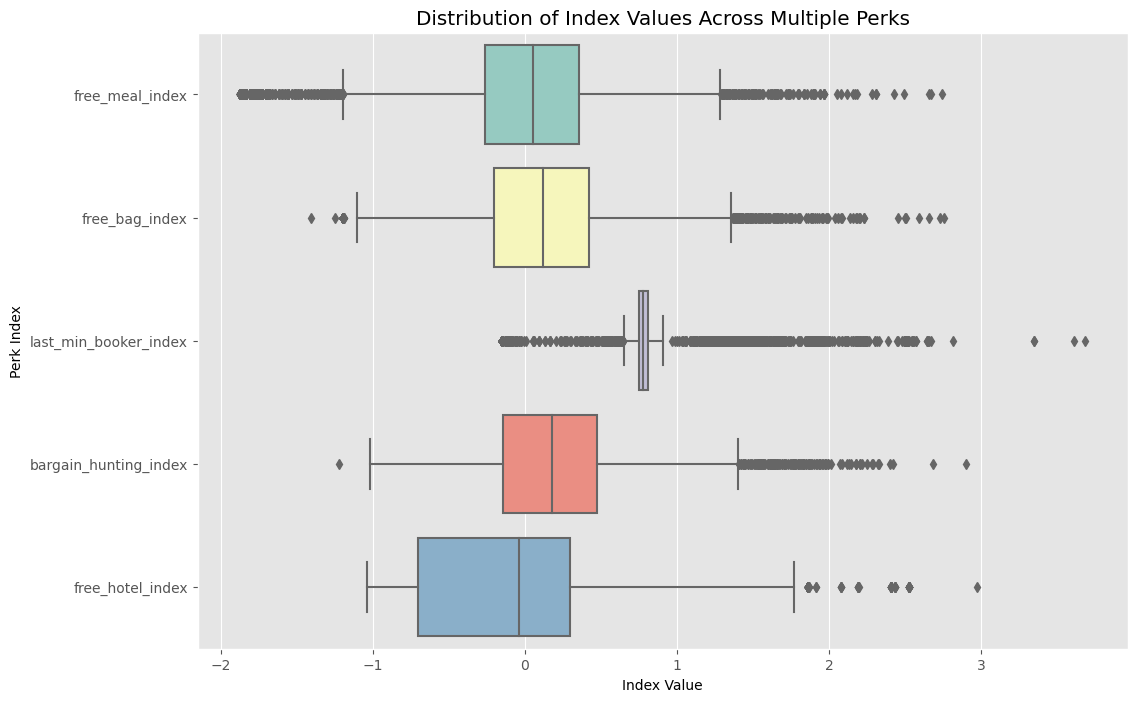

In [48]:
# Create a DataFrame containing only the perk index values for each user
perk_values_df = cohort_users[index_columns]

# Plotting the distribution of index values across multiple perks for each user
plt.figure(figsize=(12, 8))
sns.boxplot(data=perk_values_df, orient="h", palette="Set3")
plt.title('Distribution of Index Values Across Multiple Perks')
plt.xlabel('Index Value')
plt.ylabel('Perk Index')
plt.show()

<u>**Distribution of Index Values Across Multiple Perks**</u>

The provided boxplot offers a comprehensive visualization of how index values are distributed across five distinct perks. In this representation, each horizontal line corresponds to one of the five perks, while the box encapsulates the interquartile range of index values. Put simply, the width of the box indicates the degree of variability in customer preferences for that specific perk.

1. **Last-Minute Booker Index**: The range of index values is notably wide, indicating a diverse spectrum of customer behaviors related to cancellations and last-minute bookings. This suggests that a substantial number of customers are genuinely concerned about cancellation fees, aligning with Elena's proposal.

2. **Free Meal Index**: Similar to the Last-Minute Booker Index, the Free Meal Index also exhibits a broad range. This implies that the inclusion of free meals in hotels could serve as a significant motivator for a wide array of customers, further corroborating Elena's insights.

3. **Bargain Hunting Index and Free Hotel Index**: These two indexes also demonstrate a considerable range, though not as extensive as the first two. Nevertheless, it indicates that these perks could appeal to a somewhat diverse customer base.

4. **Free Bag Index**: Interestingly, this index showcases the narrowest range, suggesting that the offer of free checked bags may resonate with a smaller yet still substantial segment of customers.

<u>**Key Insight:**</u>

While each index is crafted to gauge the affinity for a specific perk, the considerable range in index values across multiple perks implies that customers may share overlapping preferences. In other words, a customer with a high index value for "No Cancellation Fees" may also exhibit a high index value for "Free Checked Bags." This overlap presents an opportunity for bundling perks or devising tiered reward programs.

By recognizing this overlap, we can more effectively tailor our rewards program to cater to diverse customer needs, potentially enhancing customer satisfaction and fostering loyalty.

# Customer Segmentation Analysis and Next Steps

The considerable overlap in high index values across multiple perks reveals that while we've segmented users based on their highest preference, many customers exhibit strong secondary preferences as well. This is a valuable insight, as it prompts us to think beyond a one-perk-per-customer model.

For instance, in future phases of the rewards program, we might explore the concept of tiered or rotating sets of perks. This approach would enable us to cater to these secondary preferences, ultimately elevating customer satisfaction and engagement with the rewards program.

<u>**Key Insights:**</u>

1. **User Preferences Align with Proposed Perks**: The segmentation affirms that the Marketing team's proposed perks resonate well with specific customer behaviors. The highest affinity segments, namely "Exclusive Discounts" and "1-night Free Hotel with a Flight," each comprising over 1,200 customers, signify a sizable customer base that would highly value these perks.

2. **Polarizing Perks Capture Varied Customer Interests**: The index distributions for "No Cancellation Fees" and "Free Hotel Meal" are notably wider, indicating greater variability in customer affinity for these perks. This implies that some customers highly prize these options, while others do not. For instance, customers who book travel far in advance may not perceive the value in a "No Cancellation Fees" perk. This polarizing nature isn't necessarily negative; it enables us to accommodate a broader range of customer interests.

3. **Overlap in Perk Preferences**: Although each user is assigned to only one segment, the index values indicate that many users possess relatively high scores in multiple perks. This suggests that while we segment users based on their primary preference, they may also hold interest in other perks. This provides an opportunity for cross-promotion or the implementation of tiered reward systems.

4. **Opportunity for More Customized Offerings**: The segmentation underscores our opportunity to offer more nuanced perks tailored to the secondary preferences of our customers. This approach will enable us to create a more compelling and personalized rewards program over time.

<u>**Recommendations:**</u>

1. **Launch Pilot Programs for Top Segments**: Initiate pilot programs targeting customers in the "Exclusive Discounts" and "1-night Free Hotel with a Flight" segments, considering their substantial sizes.

2. **Consider Tiered or Rotating Perks**: Given the overlap in perk preferences, contemplate offering a tiered or rotating selection of perks that allow customers to choose from a small array every few months. This approach caters to secondary preferences and maintains the rewards program's freshness.

3. **Performance Monitoring**: Keep a close watch on key performance indicators (KPIs) such as engagement rate, conversion rate, and customer lifetime value to assess the effectiveness of these personalized campaigns.

4. **Explore Partnerships for Exclusive Discounts**: As "Exclusive Discounts" exhibits a broad distribution, explore partnerships with airlines or hotels to provide limited-time discounts, appealing to customers with a high affinity for this perk.

5. **Optimize for Seasonal Variability**: Account for the seasonality in travel bookings to offer targeted perks. For instance, "1-night Free Hotel with a Flight" could be more appealing during peak travel seasons.

6. **Periodic Re-segmentation**: Recognize that customer preferences can evolve over time. Regularly updating these segments will ensure that our marketing efforts remain aligned with evolving customer needs.

With these insights in hand, we are now prepared to finalize our segmented list of customers, each assigned to the perk they are most likely to appreciate. This dataset will serve as the cornerstone for the pilot phase of our rewards program. Our next step involves exporting the segmented data to a CSV file, which will include each customer's user_id and their respective segment label. This resource will prove invaluable for downstream marketing activities.

In [41]:
# Select the columns to include in the final segmentation DataFrame
selected_columns = ['user_id', 'sign_up_date', 'age', 'gender', 'married', 'has_children', 'home_country', 'home_city', 'age_group', 'segment_label']

# Create the final segmentation DataFrame
final_segmentation_df = cohort_users[selected_columns]

# Save the DataFrame to a CSV file remember to update to file path with the correct one on your system 
final_segmentation_df.to_csv('TravelTide_Customer_Segmentation.csv', index=False)

# Display the first few rows of the final DataFrame
final_segmentation_df.head()


,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,age_group,segment_label
0,153982,2022-04-19,43,F,False,True,canada,toronto,35-49,Free checked bag
1,174997,2022-05-10,30,F,False,False,usa,grand rapids,19-34,Exclusive discounts
2,181157,2022-05-15,51,F,True,False,usa,houston,50-64,Free checked bag
3,189676,2022-05-23,34,F,False,True,usa,fort worth,19-34,Exclusive discounts
4,226367,2022-06-25,41,F,False,False,usa,washington,35-49,Free hotel meal


# Concluding Thoughts

Finally, we can observe the distribution of preferences among our 5,998 users for the perks:

1. Exclusive Discounts: 27.3%
2. 1-night Free Hotel with a Flight: 23.2%
3. Free Checked Bag: 20.0%
4. Free Hotel Meal: 18.0%
5. No Cancellation Fees: 11.6%

Commentary:

Based on the distribution of preferences among our users, there are a few key insights to consider when prioritizing and focusing on perks:

1. **Exclusive Discounts (27.3%):** This perk has the highest affinity among our user base, indicating that a significant portion of customers is price-sensitive and values discounts. Given its popularity, it's a strong candidate for prioritization in our rewards program.

2. **1-night Free Hotel with a Flight (23.2%):** This perk closely follows Exclusive Discounts in terms of popularity. It appeals to frequent travelers who book flights and hotels together. It should also be a top priority due to its strong user base.

3. **Free Checked Bag (20.0%):** While slightly less popular than the previous two perks, Free Checked Bag still has a substantial user base. This is particularly attractive to travelers who are conscious of baggage fees. It should be considered as a valuable perk to offer.

4. **Free Hotel Meal (18.0%):** Though not the top preference, Free Hotel Meal garners a significant portion of our user base. It tends to appeal to older customers and may be an excellent choice for targeting a specific demographic within our audience.

5. **No Cancellation Fees (11.6%):** This perk has the smallest user base among the top five preferences. It's crucial to offer this perk for customers who highly value flexibility, but it may not need to be the primary focus in the initial phase.

In summary, our data suggests that prioritizing Exclusive Discounts and 1-night Free Hotel with a Flight should be the main focus due to their widespread appeal. However, Free Checked Bag and Free Hotel Meal also have substantial user bases and should be given attention. While No Cancellation Fees is essential for some users, it may be considered a secondary perk in the initial stages of our rewards program. Overall, a balanced approach that caters to the diverse preferences of our user base is likely to yield the best results.

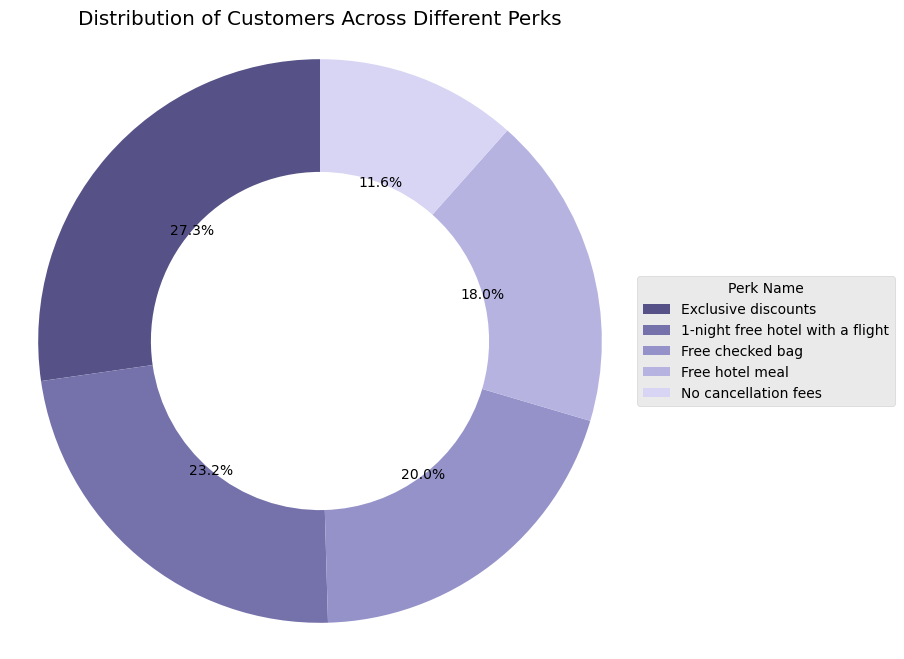

In [49]:
# Create a dictionary to map the index names to the perk names
perk_names = {
    'free_meal_index': 'Free hotel meal',
    'free_bag_index': 'Free checked bag',
    'last_min_booker_index': 'No cancellation fees',
    'bargain_hunting_index': 'Exclusive discounts',
    'free_hotel_index': '1-night free hotel with a flight'
}

# Add a new column for the perk names
perk_distribution['Perk Name'] = perk_distribution['Best Index'].map(perk_names)

# Create a cubehelix color palette with reversed intensity (high to low)
custom_palette = sns.cubehelix_palette(len(perk_distribution), start=3, rot=0, dark=0.35, light=0.85, reverse=True)

# Plot a donut chart with percentages
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    perk_distribution['Number of Customers'],
    labels=None,
    autopct='%1.1f%%',  # Display percentages
    startangle=90,
    wedgeprops=dict(width=0.4),
    colors=custom_palette
)

# Draw a circle to make it a donut chart
circle = plt.Circle((0, 0), 0.3, fc='white')
fig.gca().add_artist(circle)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create a legend (key) for the chart
ax.legend(wedges, perk_distribution['Perk Name'], title='Perk Name', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Customers Across Different Perks')
plt.show()